<a href="https://colab.research.google.com/github/metorkhai/DATA-MINING/blob/main/Mining_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_excel("/content/sample_data/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print("Kích thước ban đầu:", df.shape)
print("\nThông tin tổng quan về các cột:")
print(df.info())


Kích thước ban đầu: (541909, 8)

Thông tin tổng quan về các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


#  Làm sạch &amp; tiền xử lý dữ liệu



## 1. Chuyển InvoiceData sang dạng datetime, tách ra ngày/giờ/tháng

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,8,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,8,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12


## 2. Xử lý Quantity âm (loại hoặc đánh dấu là hủy đơn)

- Trước hết kiểm tra xem có bao nhiêu phần trăm Quantity âm và InvoiceNo có 'c' ở đầu (nghĩa là đơn bị hủy) chủ yếu là để phân tích xem tại sao hủy đơn mà nếu không quá 5% thì có thế xóa vì quá ít để phân tích

In [ ]:
# Check for negative quantities
negative_quantity_rows = df[df['Quantity'] < 0]
num_negative_quantity = negative_quantity_rows.shape[0]
percent_negative_quantity = (num_negative_quantity / df.shape[0]) * 100

print(f"Số lượng giá trị âm ở cột Quantity: {num_negative_quantity}")
print(f"Phần trăm âm ở cột  Quantity: {percent_negative_quantity:.2f}%")

Số lượng giá trị âm ở cột Quantity: 10624
Phần trăm âm ở cột  Quantity: 1.96%


In [ ]:
# Create a copy of the dataframe
df_copy = df.copy()
# Check for 'C' in InvoiceNo
invoice_with_c = df_copy[df_copy['InvoiceNo'].astype(str).str.contains('C', na=False)]
num_invoice_with_c = invoice_with_c.shape[0]
percent_invoice_with_c = (num_invoice_with_c / df_copy.shape[0]) * 100

print(f"Số lượng đơn có 'c' ở đầu trong cột InvoiceNo: {num_invoice_with_c}")
print(f"Phần trăm đơn có 'c' ở đầu trong cột InvoiceNo: {percent_invoice_with_c:.2f}%")


Số lượng đơn có 'c' ở đầu trong cột InvoiceNo: 9288
Phần trăm đơn có 'c' ở đầu trong cột InvoiceNo: 1.71%


In [ ]:
invoice_cancellation_rows = df_copy[df_copy['InvoiceNo'].astype(str).str.startswith('C', na=False)]
print("Số lượng mà đơn hàng bị hủy (có 'c' ở đầu) thì sẽ có giá trị âm ở quantity:",invoice_cancellation_rows.shape[0])
print()
print("Những dòng mà có  'C':")
display(invoice_cancellation_rows)

Số lượng mà đơn hàng bị hủy (có 'c' ở đầu) thì sẽ có giá trị âm ở quantity: 9288

Những dòng mà có  'C':


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,9,12
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1,9,12
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1,10,12
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,10,12
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,10,12
...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,9,9,12
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,9,10,12
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,9,11,12
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,9,11,12


Sau khi kiểm tra xem thì có 9288 dòng là đơn bị hủy chiếm 1.71% và 10624 dòng có giá trị âm 1.96% , và các dòng có đơn hủy và có Quantity âm là 9288. Thì không quá nhiều thì ta xóa.

In [ ]:
df = df[df['Quantity'] > 0]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print( "Sau khi xóa các dòng dữ liệu hủy đơn và Quantity âm:", df.shape)


Sau khi xóa các dòng dữ liệu hủy đơn và Quantity âm: (531285, 11)


##3. Xử lý dòng thiếu CustomerID, Description (bổ sung, bỏ, hoặc coi như khách vãng lai).

- Trước hết kiểm tra xem 'Description', 'CustomerID' thiếu bao nhiêu để xử lý



In [ ]:
missing_values = df[['Description', 'CustomerID']].isnull().sum()
missing_percent = df[['Description', 'CustomerID']].isnull().mean() * 100

print("Số lượng giá trị missing trong hai cột:")
print(missing_values)
print("\nPhần trăm giá trị missing trong hai cột:")
print(missing_percent)

Số lượng giá trị missing trong hai cột:
Description       592
CustomerID     133361
dtype: int64

Phần trăm giá trị missing trong hai cột:
Description     0.111428
CustomerID     25.101593
dtype: float64


Sau khi kiểm tra thì Description thiếu không nhiều thì xóa
Nhưng đối với CustomerID thì thiếu khá nhiều khoảng 25% nên không thể xóa vì có thê ảnh hướng để khai thác dữ liệu và dự đoán nên ta giữ lại xem như khách vãng lại

In [ ]:
df = df.dropna(subset=[ 'Description'])

print(df.shape)

(530693, 11)


In [ ]:
# Xem CustomerID như khách vãng lai
df['CustomerID'].fillna(0, inplace=True)
print(df.shape)

(530693, 11)


Chuyển chữ thường của Description giúp chuẩn hóa dữ liệu, giảm lỗi so khớp, và đảm bảo khi tìm kiếm, đếm hoặc phân loại sản phẩm, bạn không bị phân biệt bởi chữ hoa/chữ thường.

In [ ]:
# chuẩn hóa thành chữ thường và bỏ khoảng trống 2 bên
df['Description'] = df['Description'].str.lower().str.strip()
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,8,12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,8,12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12


##4.Loại bỏ ngoại lệ rõ ràng (UnitPrice hay Quantity quá lớn) và giải thích lý do.


Trước hết là kiểm tra xem có bao nhiêu dòng ở cột UnitPrice âm or bằng không

In [ ]:
# Check for UnitPrice equal to 0 or negative
zero_or_negative_price_rows = df[df['UnitPrice'] <= 0]
num_zero_or_negative_price = zero_or_negative_price_rows.shape[0]
percent_zero_or_negative_price = (num_zero_or_negative_price / df.shape[0]) * 100

print(f"Số lượng giá trị âm or bằng 0 ở cột UnitPrice: {num_zero_or_negative_price}")
print(f"Phần trăm các giá trị âm or bằng 0 ở cột UnitPrice: {percent_zero_or_negative_price:.2f}%")



Số lượng giá trị âm or bằng 0 ở cột UnitPrice: 589
Phần trăm các giá trị âm or bằng 0 ở cột UnitPrice: 0.11%


Kiểm tra được là 0.11% là âm or bằng  0 thì có thể là nhập thiếu có thể xóa


In [ ]:
# Display rows with negative UnitPrice
# Corrected filtering syntax
negative_price_rows = df[df['UnitPrice'] <= 0]
negative_price_rows.shape[0]
print("Rows with negative UnitPrice:")
display(negative_price_rows)

Rows with negative UnitPrice:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,0.0,United Kingdom,3,12,12
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,0.0,United Kingdom,3,12,12
9302,537197,22841,round cake tin vintage green,1,2010-12-05 14:02:00,0.0,12647.0,Germany,5,14,12
14335,537534,85064,cream sweetheart letter rack,1,2010-12-07 11:48:00,0.0,0.0,United Kingdom,7,11,12
14336,537534,84832,zinc willie winkie candle stick,1,2010-12-07 11:48:00,0.0,0.0,United Kingdom,7,11,12
...,...,...,...,...,...,...,...,...,...,...,...
524622,580609,22927,amazon,1,2011-12-05 11:41:00,0.0,0.0,United Kingdom,5,11,12
535325,581202,23404,check,41,2011-12-07 18:30:00,0.0,0.0,United Kingdom,7,18,12
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,0.0,United Kingdom,7,18,12
538504,581406,46000M,polyester filler pad 45x45cm,240,2011-12-08 13:58:00,0.0,0.0,United Kingdom,8,13,12


In [ ]:
# Filter the DataFrame to show rows where 'StockCode' is exactly 'B'
stockcode_b_rows = df[df['StockCode'] == 'B']

print("Rows where StockCode is 'B':")
display(stockcode_b_rows)

Rows where StockCode is 'B':


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month
299982,A563185,B,adjust bad debt,1,2011-08-12 14:50:00,11062.06,0.0,United Kingdom,12,14,8
299983,A563186,B,adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0.0,United Kingdom,12,14,8
299984,A563187,B,adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0.0,United Kingdom,12,14,8


Sau khi phân tích thêm thì thấy là giá trị âm khá cao và khi kiểm tra thêm thì thấy mã sản phẩm này chỉ có 3 thôi mà có 1 giá trị khá lớn nên xóa luôn mã này vì sẽ làm sai lệch doanh thu và giá trị Monetary.

In [ ]:
# Remove rows where UnitPrice is 0 or negative
df = df[df['UnitPrice'] > 0]

# Remove rows where StockCode is 'B'
df = df[df['StockCode'] != 'B']

print("Sau khi loại bỏ các hàng bằng UnitPrice <= 0 và StockCode = 'B': ", df.shape)

Sau khi loại bỏ các hàng bằng UnitPrice <= 0 và StockCode = 'B':  (530103, 11)


Tiếp đến chúng ta sẽ xem thử có các giá trị lớn hơn mức bình thường không

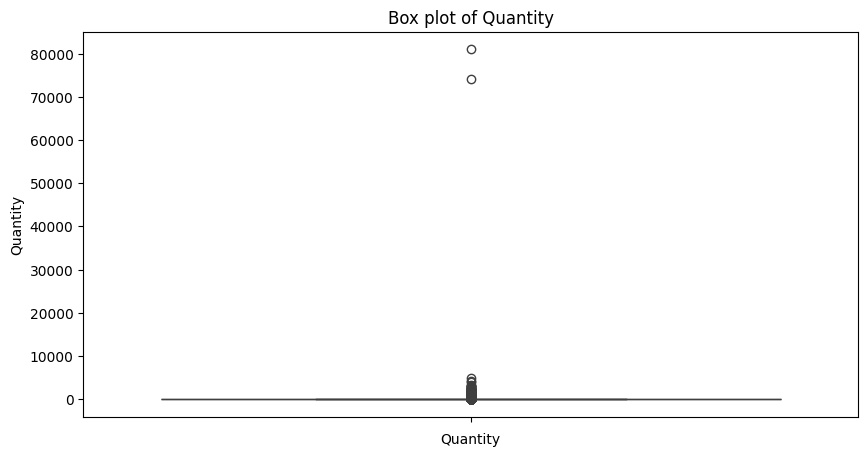

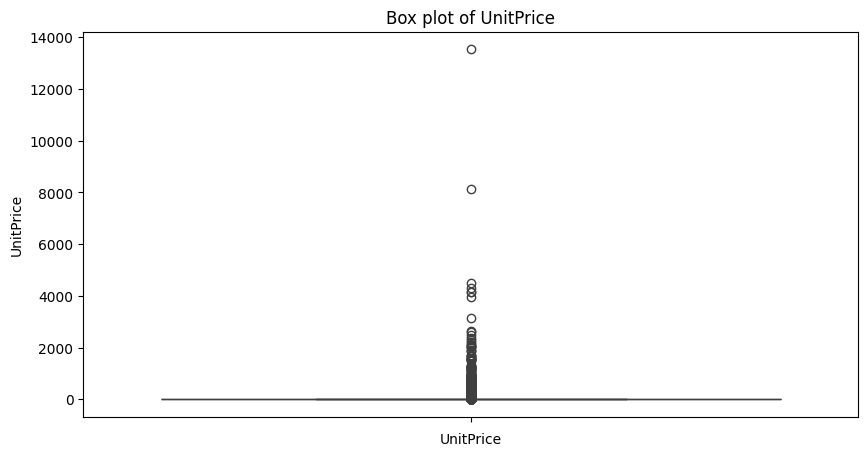

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize potential outliers in 'Quantity'
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['Quantity'])
plt.title('Box plot of Quantity')
plt.xlabel('Quantity')
plt.show()

# Visualize potential outliers in 'UnitPrice'
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['UnitPrice'])
plt.title('Box plot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

Khá là nhiều giá trị bất thường nên sẽ làm thêm 1 vài biểu đồ để xem rõ hơn

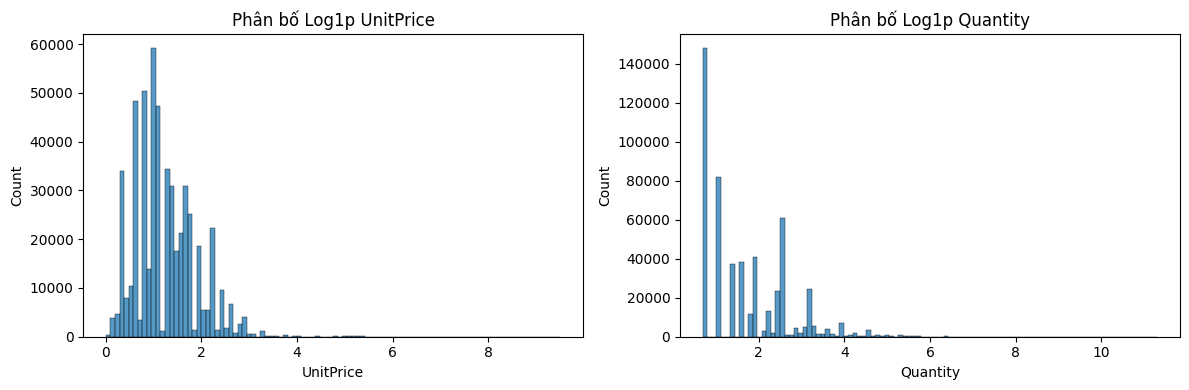

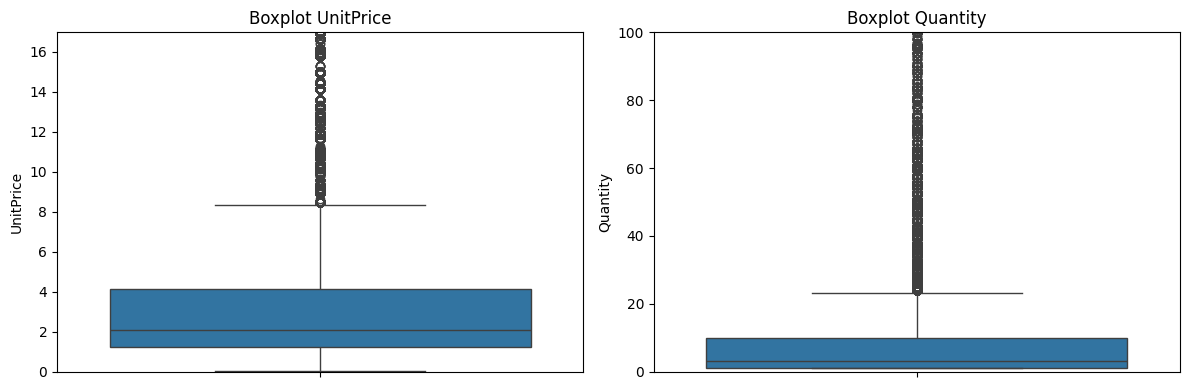

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Histogram: xem phân bố chung
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(np.log1p(df['UnitPrice']), bins=100, ax=axes[0])
axes[0].set_title('Phân bố Log1p UnitPrice')

sns.histplot(np.log1p(df['Quantity']), bins=100, ax=axes[1])
axes[1].set_title('Phân bố Log1p Quantity')
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

# 2) Boxplot: dễ nhìn outlier
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(y=df['UnitPrice'], ax=axes[0])
axes[0].set_title('Boxplot UnitPrice')
axes[0].set_ylim(0, df['UnitPrice'].quantile(0.99)) # Limit y-axis to 99th percentile


sns.boxplot(y=df['Quantity'], ax=axes[1])
axes[1].set_title('Boxplot Quantity')
axes[1].set_ylim(0, df['Quantity'].quantile(0.99)) # Limit y-axis to 99th percentile
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

Thì sau nhìn biểu đồ thì ta có thể thấy rõ là có khá nhiều dữ liệu ngoại lai nhưng chúng ta có thể giữ để dùng cho phân nhóm khách hàng và có thể xử lý sau

In [ ]:
num_transactions = df['InvoiceNo'].nunique()
num_customers = df['CustomerID'].nunique()
num_products = df['StockCode'].nunique()
num_countries = df['Country'].nunique()


print(f"Số lượng giao dịch: {num_transactions}")
print(f"Số lượng khách hàng: {num_customers}")
print(f"Số lượng sản phẩm: {num_products}")
print(f"Số lượng các quốc gia: {num_countries}")
print("dữ liệu sau khi làm sạch", df.shape)
print(df.info())


Số lượng giao dịch: 19959
Số lượng khách hàng: 4339
Số lượng sản phẩm: 3921
Số lượng các quốc gia: 38
dữ liệu sau khi làm sạch (530103, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 530103 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530103 non-null  object        
 1   StockCode    530103 non-null  object        
 2   Description  530103 non-null  object        
 3   Quantity     530103 non-null  int64         
 4   InvoiceDate  530103 non-null  datetime64[ns]
 5   UnitPrice    530103 non-null  float64       
 6   CustomerID   530103 non-null  float64       
 7   Country      530103 non-null  object        
 8   Day          530103 non-null  int32         
 9   Hour         530103 non-null  int32         
 10  Month        530103 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(4)
memory usage: 42.5+ MB
None


# Phân tích khám phá dữ liệu (EDA)

## Tính toán cột doanh thu

Tạo một cột mới tính toán doanh thu cho mỗi dòng dữ liệu (`Quantity * UnitPrice`).


In [ ]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month,Amount
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,8,12,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,8,12,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34


## Phân tích doanh thu theo thời gian

Tổng hợp doanh thu theo ngày và trực quan hóa xu hướng doanh thu hàng ngày. Tổng hợp doanh thu theo tháng và trực quan hóa xu hướng doanh thu hàng tháng.


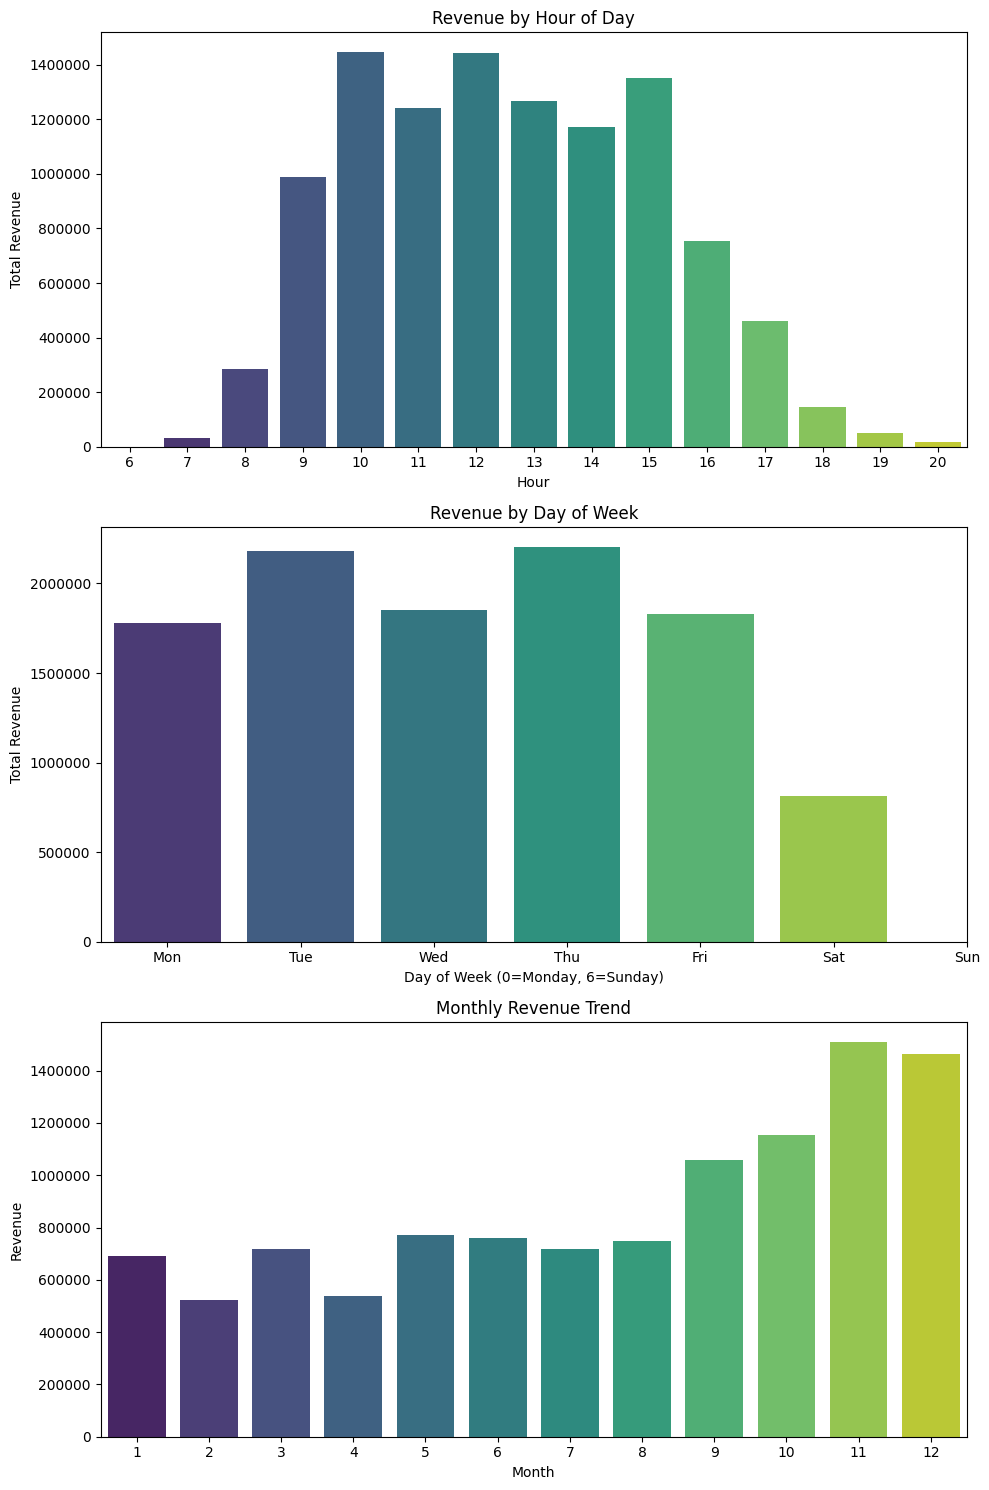

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for better organization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Group by Hour and sum the 'Amount' for revenue by hour
revenue_by_hour = df.groupby('Hour')['Amount'].sum().reset_index()

# Plot revenue by hour of day
sns.barplot(x='Hour', y='Amount', data=revenue_by_hour, palette='viridis', ax=axes[0])
axes[0].set_title('Revenue by Hour of Day')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Total Revenue')
axes[0].ticklabel_format(style='plain', axis='y') # Disable scientific notation on y-axis

# Group by DayOfWeek and sum the 'Amount' for revenue by day of week
revenue_by_dayofweek = df.groupby(df['InvoiceDate'].dt.dayofweek)['Amount'].sum().reset_index()
revenue_by_dayofweek = revenue_by_dayofweek.sort_values(by='InvoiceDate') # Sort by day of week (0=Monday, 6=Sunday)

# Plot revenue by day of week
sns.barplot(x='InvoiceDate', y='Amount', data=revenue_by_dayofweek, palette='viridis', ax=axes[1])
axes[1].set_title('Revenue by Day of Week')
axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[1].set_ylabel('Total Revenue')
axes[1].set_xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Set x-axis labels
axes[1].ticklabel_format(style='plain', axis='y') # Disable scientific notation on y-axis


# Group by Month and sum the 'Amount' for monthly revenue
monthly_revenue = df.groupby('Month')['Amount'].sum().reset_index()


# Plot monthly revenue trend
sns.barplot(data=monthly_revenue, x='Month', y='Amount', palette='viridis', ax=axes[2])
axes[2].set_title('Monthly Revenue Trend')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Revenue')
axes[2].ticklabel_format(style='plain', axis='y') # Disable scientific notation on y-axis

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

## Xác định sản phẩm bán chạy nhất

Tính tổng doanh thu cho từng sản phẩm và xác định 10 sản phẩm có doanh thu cao nhất. Tính tổng số lượng bán ra cho từng sản phẩm và xác định 10 sản phẩm bán chạy nhất theo số lượng. Trực quan hóa kết quả.


In [ ]:
# Calculate total revenue for each product and get the top 10
top_revenue_products = df.groupby('Description')['Amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Calculate total quantity sold for each product and get the top 10
top_quantity_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()

from IPython.display import display

# Giả sử đã có 2 DataFrame: top_revenue_products, top_quantity_products
combined = pd.concat(
    [top_revenue_products, top_quantity_products],
    axis=1,
    keys=['Top by Revenue', 'Top by Quantity']  # tiêu đề cột
)

display(combined)

Top by Revenue             \
                          Description     Amount   
0                      dotcom postage  206248.77   
1            regency cakestand 3 tier  174484.74   
2         paper craft , little birdie  168469.60   
3  white hanging heart t-light holder  106292.77   
4                       party bunting   99504.33   
5             jumbo bag red retrospot   94340.05   
6      medium ceramic top storage jar   81700.92   
7                              manual   78112.82   
8                             postage   78101.88   
9                  rabbit night light   66964.99   

                      Top by Quantity           
                          Description Quantity  
0         paper craft , little birdie    80995  
1      medium ceramic top storage jar    78033  
2   world war 2 gliders asstd designs    55047  
3             jumbo bag red retrospot    48474  
4  white hanging heart t-light holder    37891  
5                      popcorn holder    36761  
6       assorted colour bird ornament    36461  
7     pack of 72 retrospot cake cases    36419  
8                  rabbit night light    30788  
9              mini paint set vintage    26633

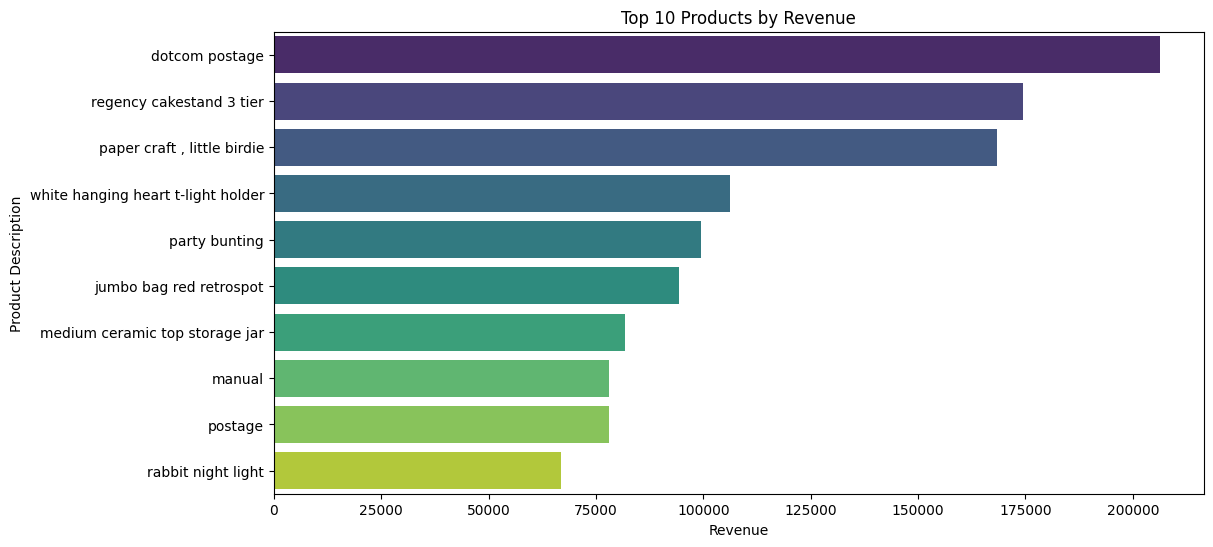

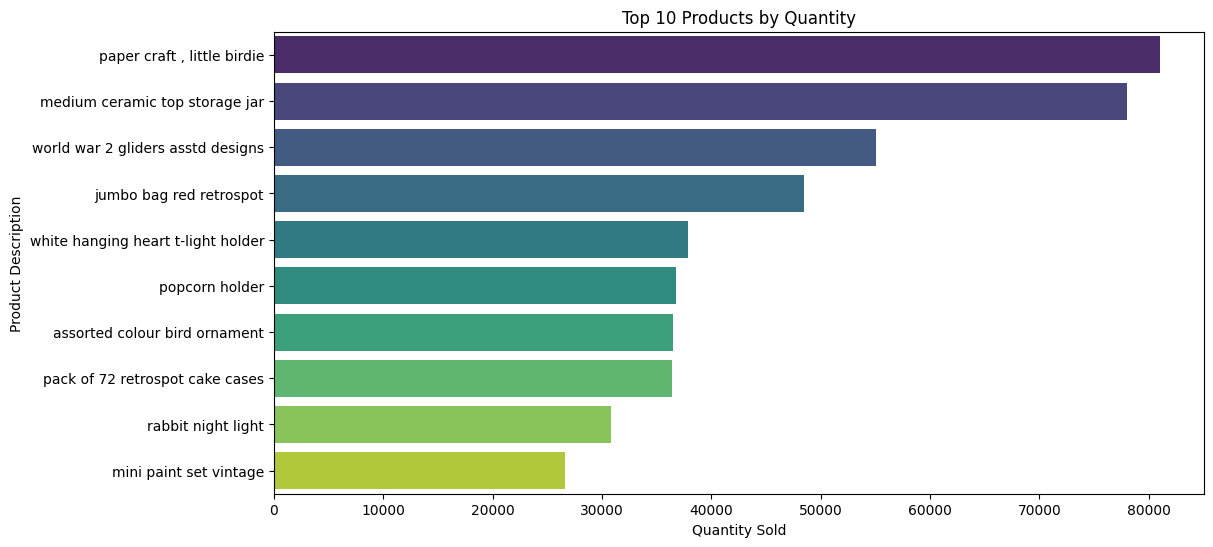

In [ ]:
# Plot top 10 products by revenue
plt.figure(figsize=(12, 6))
sns.barplot(x='Amount', y='Description', data=top_revenue_products, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product Description')
plt.show()

# Plot top 10 products by quantity
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_quantity_products, palette='viridis')
plt.title('Top 10 Products by Quantity')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()

## Phân tích doanh thu theo quốc gia

Tính tổng doanh thu cho mỗi quốc gia và xác định các quốc gia đóng góp nhiều doanh thu nhất. Trực quan hóa doanh thu theo quốc gia.


In [ ]:
revenue_by_country = df.groupby('Country')['Amount'].sum().reset_index()
revenue_by_country = revenue_by_country.sort_values(by='Amount', ascending=False)
print("Doanh thu theo quốc gia:")
display(revenue_by_country)

Doanh thu theo quốc gia:


,Country,Amount
36,United Kingdom,9014160.024
24,Netherlands,285446.340
10,EIRE,283453.960
14,Germany,228867.140
13,France,209715.110
0,Australia,138521.310
31,Spain,61577.110
33,Switzerland,57089.900
3,Belgium,41196.340
32,Sweden,38378.330


In [ ]:
import plotly.express as px

# Calculate total revenue, number of unique invoices, and number of unique customers per country
country_analysis = df.groupby('Country').agg(
    TotalRevenue=('Amount', 'sum'),
    NumberOfOrders=('InvoiceNo', 'nunique'),
    NumberOfCustomers=('CustomerID', 'nunique')
).reset_index()

# Create a treemap for revenue proportion by country, including additional data on hover
fig = px.treemap(country_analysis, path=['Country'], values='TotalRevenue',
                 title='Proportion of Total Revenue by Country',
                 hover_data=['NumberOfOrders', 'NumberOfCustomers']) # Add hover data
fig.show()

## Phân tích doanh thu theo thời gian trong ngày

Tổng hợp doanh thu theo giờ trong ngày và trực quan hóa.


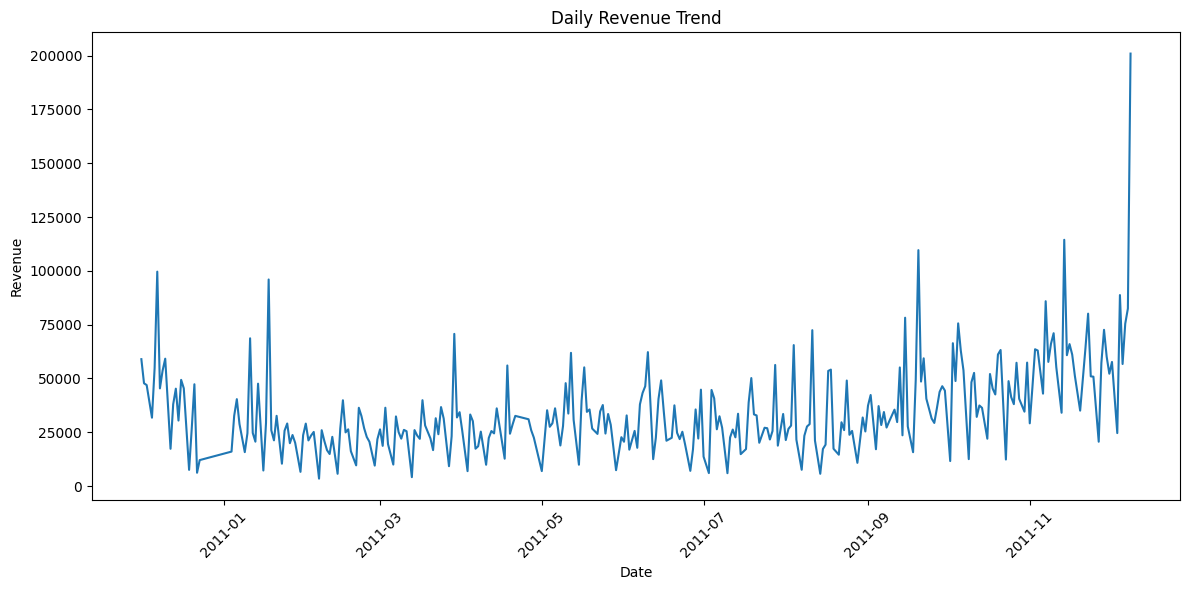

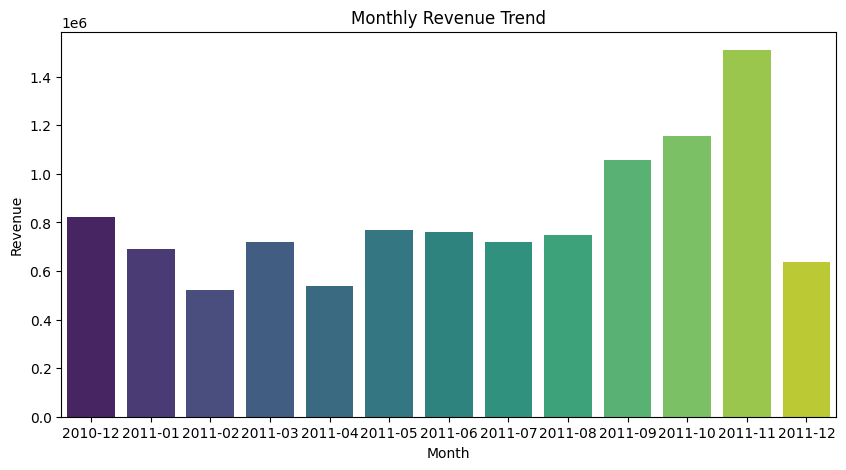

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate daily revenue
daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['Amount'].sum().reset_index()
daily_revenue['InvoiceDate'] = pd.to_datetime(daily_revenue['InvoiceDate']) # Convert back to datetime for plotting

# Plot daily revenue trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceDate', y='Amount', data=daily_revenue)
plt.title('Daily Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate monthly revenue
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Amount'].sum().reset_index()
monthly_revenue['InvoiceDate'] = monthly_revenue['InvoiceDate'].astype(str) # Convert Period to string for plotting

# Plot monthly revenue trend
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_revenue, x='InvoiceDate', y='Amount', palette='viridis')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

## Phân tích phân phối kích cỡ giỏ hàng

Tính số lượng sản phẩm trong mỗi hóa đơn (kích cỡ giỏ hàng). Trực quan hóa phân bố kích cỡ giỏ hàng.


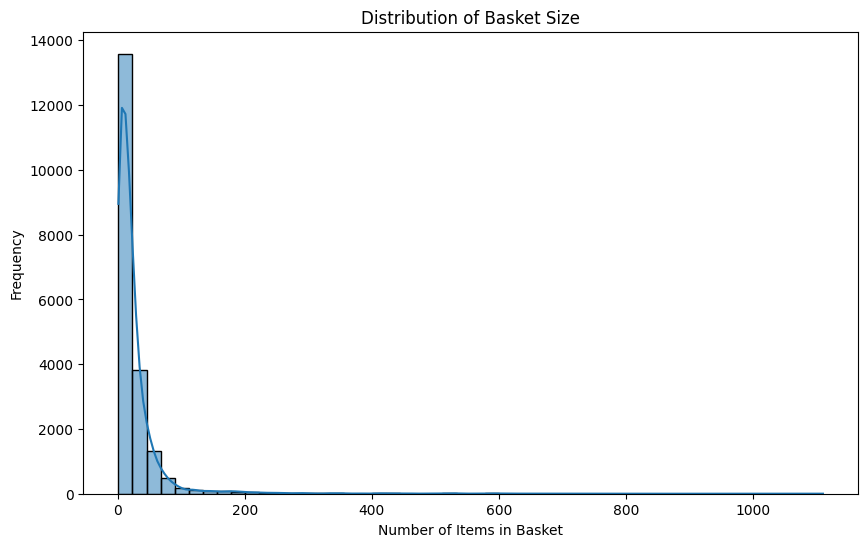

In [ ]:
basket_size = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
basket_size.rename(columns={'StockCode': 'BasketSize'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.histplot(basket_size['BasketSize'], bins=50, kde=True)
plt.title('Distribution of Basket Size')
plt.xlabel('Number of Items in Basket')
plt.ylabel('Frequency')
plt.show()

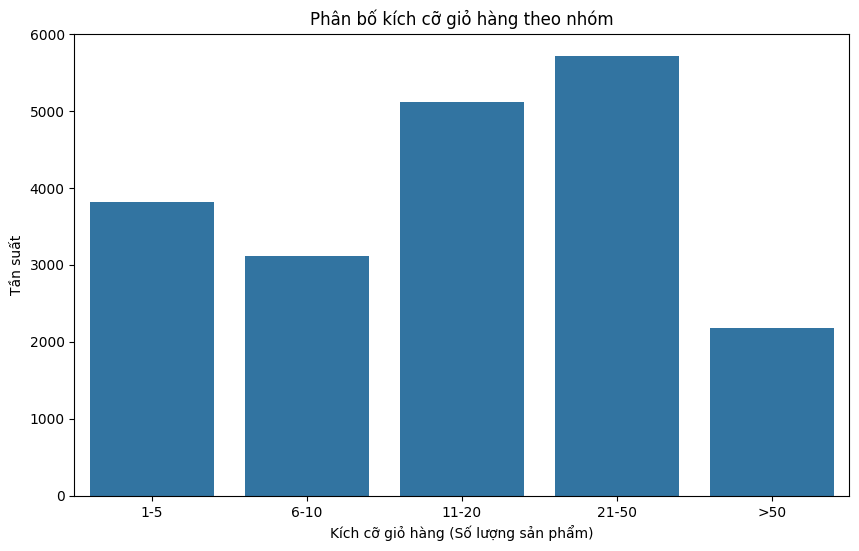

In [ ]:
bins = [0, 5, 10, 20, 50, 1000]
labels = ["1-5", "6-10", "11-20", "21-50", ">50"]

if isinstance(basket_size, pd.DataFrame) and 'BasketSize' in basket_size.columns:
    basket_bins = pd.cut(basket_size['BasketSize'], bins=bins, labels=labels, right=False)
elif isinstance(basket_size, pd.Series):
    basket_bins = pd.cut(basket_size, bins=bins, labels=labels, right=False)
else:
    print("Error: basket_size is not in the expected format (DataFrame with 'BasketSize' or Series)")
    basket_bins = None # Or handle the error appropriately

if basket_bins is not None:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=basket_bins, order=labels)
    plt.title("Phân bố kích cỡ giỏ hàng theo nhóm")
    plt.xlabel("Kích cỡ giỏ hàng (Số lượng sản phẩm)")
    plt.ylabel("Tần suất")
    plt.show()

# Phân khúc khách hàng theo RFM

## Tính toán chỉ số rfm

Tính Recency, Frequency, và Monetary cho từng khách hàng.
- Nhưng trước hết thì phải xử lý các khách hàng có id là 0 vì trong phần này chúng ta sẽ phân cụm để tìm ra group các khách hàng  vip, mua 1 lần và trung bình nếu để id là 0 thì nó sẽ coi là 1 khách hàng và sẽ ảnh hưởng đến phân cụm



In [ ]:
from datetime import datetime

# Create a copy of the dataframe for RFM analysis
df_rfm = df.copy()

# Remove rows where CustomerID is 0
df_rfm = df_rfm[df_rfm['CustomerID'] != 0]

# Determine the analysis date
analysis_date = df_rfm['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate Recency
recency_df = df_rfm.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (analysis_date - recency_df['InvoiceDate']).dt.days
recency_df = recency_df[['CustomerID', 'Recency']]

# Calculate Frequency
frequency_df = df_rfm.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Calculate Monetary
monetary_df = df_rfm.groupby('CustomerID')['Amount'].sum().reset_index()
monetary_df.rename(columns={'Amount': 'Monetary'}, inplace=True)

# Merge R, F, and M into a single DataFrame
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

print("RFM DataFrame after removing CustomerID 0:")
display(rfm_df.head())
print("\nShape of RFM DataFrame:", rfm_df.shape)

RFM DataFrame after removing CustomerID 0:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40



Shape of RFM DataFrame: (4338, 4)


## Xử lý ngoại lệ và tạo nhóm vip

Xác định và tách các khách hàng chi tiêu lớn thành một nhóm VIP riêng.


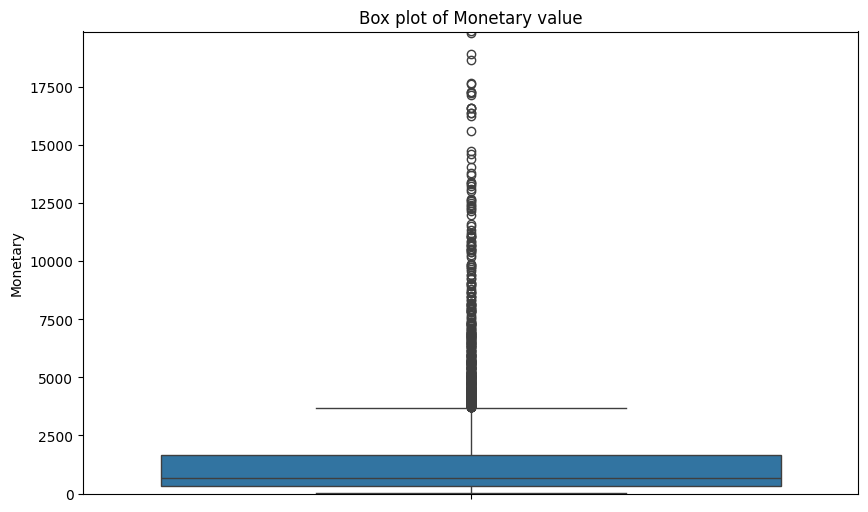

VIP Customers (identified by IQR method):


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
10,12357.0,33,1,6207.67
12,12359.0,58,4,6372.58
15,12362.0,3,10,5226.23



RFM DataFrame after removing VIP customers:


,CustomerID,Recency,Frequency,Monetary
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
5,12352.0,36,8,2506.04
6,12353.0,204,1,89.00



Shape of VIP Customers DataFrame: (427, 4)
Shape of RFM DataFrame after removing VIP customers: (3911, 4)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of Monetary value to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['Monetary'])
plt.title('Box plot of Monetary value')
plt.ylabel('Monetary')
plt.ylim(0, rfm_df['Monetary'].quantile(0.99)) # Limit y-axis to 99th percentile for better visualization
plt.show()

# Calculate IQR for Monetary value
Q1 = rfm_df['Monetary'].quantile(0.25)
Q3 = rfm_df['Monetary'].quantile(0.75)
IQR = Q3 - Q1

# Determine the threshold for VIP customers using the IQR rule (Q3 + 1.5 * IQR)
vip_threshold = Q3 + 1.5 * IQR

# Create a DataFrame for VIP customers
vip_customers_df = rfm_df[rfm_df['Monetary'] >= vip_threshold].copy()

# Remove VIP customers from the original rfm_df
rfm_df = rfm_df[rfm_df['Monetary'] < vip_threshold].copy()

print("VIP Customers (identified by IQR method):")
display(vip_customers_df.head())
print("\nRFM DataFrame after removing VIP customers:")
display(rfm_df.head())
print("\nShape of VIP Customers DataFrame:", vip_customers_df.shape)
print("Shape of RFM DataFrame after removing VIP customers:", rfm_df.shape)

## Chuẩn hóa dữ liệu rfm
Áp dụng các phép biến đổi (ví dụ: log, box-cox) và chuẩn hóa dữ liệu RFM để chuẩn bị cho phân cụm.


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select RFM columns for transformation and scaling
rfm_columns = ['Recency', 'Frequency', 'Monetary']
rfm_data = rfm_df[rfm_columns]

# Apply log transformation (using log1p to handle zero values)
rfm_log = np.log1p(rfm_data)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the log-transformed data
rfm_scaled = scaler.fit_transform(rfm_log)

# Create a new DataFrame with scaled RFM data and CustomerID
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_columns)
rfm_scaled_df['CustomerID'] = rfm_df['CustomerID'].values # Add CustomerID back

# Display the first 5 rows and info of the scaled DataFrame
display(rfm_scaled_df.head())
print("\nThông tin của DataFrame RFM đã chuẩn hóa:")
print(rfm_scaled_df.info())

,Recency,Frequency,Monetary,CustomerID
0,0.278255,0.764612,1.143853,12348.0
1,-0.769174,-0.988622,1.121784,12349.0
2,1.383789,-0.988622,-0.516590,12350.0
3,-0.286505,1.889285,1.472428,12352.0
4,1.056785,-0.988622,-1.817378,12353.0



Thông tin của DataFrame RFM đã chuẩn hóa:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recency     3911 non-null   float64
 1   Frequency   3911 non-null   float64
 2   Monetary    3911 non-null   float64
 3   CustomerID  3911 non-null   float64
dtypes: float64(4)
memory usage: 122.3 KB
None


## Xác định số lượng cụm tối ưu

Sử dụng các phương pháp như Elbow method hoặc Silhouette score để tìm số lượng cụm phù hợp cho K-means.


Inertia and Silhouette Scores for each k:
For k = 2, Inertia = 5962.58, Silhouette Score = 0.28
For k = 3, Inertia = 4669.50, Silhouette Score = 0.42
For k = 4, Inertia = 3668.54, Silhouette Score = 0.31
For k = 5, Inertia = 3169.89, Silhouette Score = 0.33
For k = 6, Inertia = 2745.23, Silhouette Score = 0.31
For k = 7, Inertia = 2473.18, Silhouette Score = 0.30
For k = 8, Inertia = 2281.98, Silhouette Score = 0.28
For k = 9, Inertia = 2096.32, Silhouette Score = 0.28
For k = 10, Inertia = 1950.46, Silhouette Score = 0.28


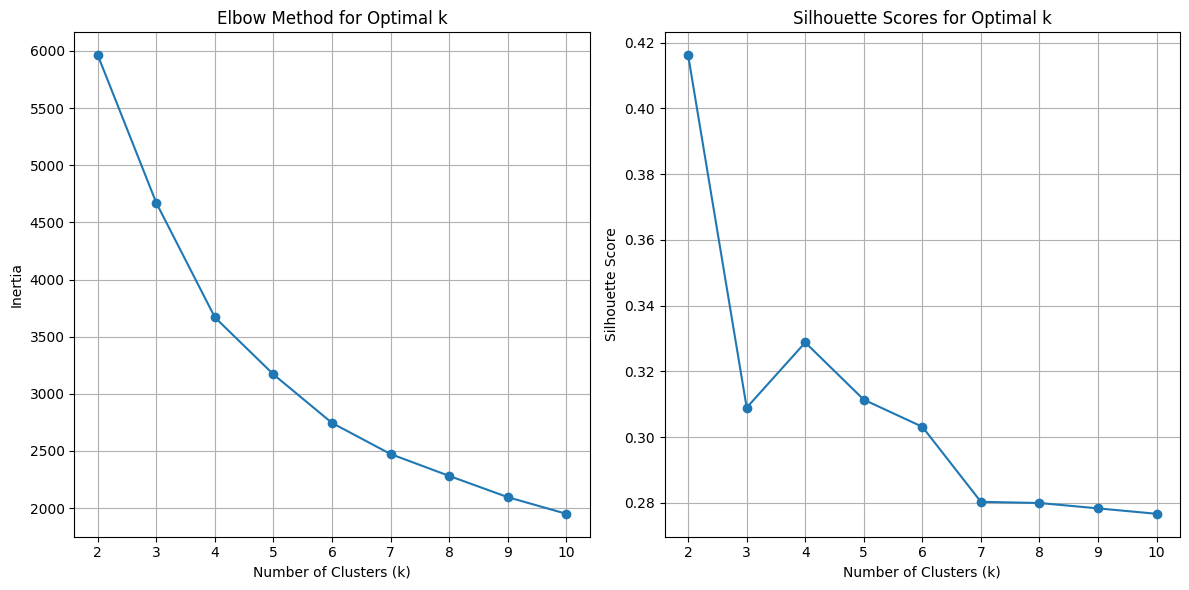

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create empty lists to store inertia and silhouette scores
inertia = []
silhouette_scores = [] # Now including silhouette scores

# Iterate through a range of possible cluster numbers
# We will try from 2 to 10 clusters
k_range = range(2, 11)

for k in k_range:
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit the KMeans model to the scaled RFM data (excluding CustomerID)
    kmeans.fit(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])

    # Append the model's inertia to the inertia list
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score for k > 1
    if k > 1:
        score = silhouette_score(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']], kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None) # Append None for k=1 as silhouette score is not defined


# Print inertia and silhouette values for each k
print("Inertia and Silhouette Scores for each k:")
for i, k in enumerate(k_range):
    if k > 1:
        print(f"For k = {k}, Inertia = {inertia[i]:.2f}, Silhouette Score = {silhouette_scores[i-1]:.2f}") # Adjust index for silhouette_scores
    else:
         print(f"For k = {k}, Inertia = {inertia[i]:.2f}, Silhouette Score = N/A")


# Create subplots for both Elbow method and Silhouette score
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Adjusted figure size for two plots

# Plot the inertia values (Elbow method)
axes[0].plot(k_range, inertia, marker='o')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(k_range)
axes[0].grid(True)


# Plot the silhouette scores
# Filter out None values for plotting
k_range_silhouette = [k for k in k_range if k > 1]
silhouette_scores_filtered = [score for score in silhouette_scores if score is not None]


axes[1].plot(k_range_silhouette, silhouette_scores_filtered, marker='o')
axes[1].set_title('Silhouette Scores for Optimal k')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(k_range_silhouette)
axes[1].grid(True)


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

## Thực hiện phân cụm k-means
Áp dụng thuật toán K-means để phân nhóm các khách hàng còn lại.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans

# --- Perform K-means Clustering ---
# Choose the optimal number of clusters (e.g., based on Elbow or Silhouette plots)
# Let's choose k=3 for demonstration based on the silhouette scores and elbow plot
n_clusters = 3 # You can change this based on your analysis in the previous step

# Initialize KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Fit the KMeans model to the scaled RFM data (excluding CustomerID)
kmeans.fit(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])

# Add the cluster labels to the original rfm_df DataFrame
rfm_df['Cluster_Label'] = kmeans.labels_


# --- 1. Tính trung bình RFM cho từng cụm ---
cluster_summary = rfm_df.groupby('Cluster_Label')[['Recency','Frequency','Monetary']].mean().reset_index()

# --- 2. Hàm gán nhãn cụm ---
def assign_cluster_name(row):
    # VIP: mua thường xuyên, chi tiêu rất cao, mới mua gần đây
    if row['Recency'] <= 30 and row['Frequency'] > 10 and row['Monetary'] > 5000:
        return 'VIP'
    # Best Customers: mua nhiều và đều, gần đây
    elif row['Recency'] <= 60 and row['Frequency'] > 5:
        return 'Khách hàng tốt nhất'
    # Inactive: lâu không mua, ít giao dịch
    elif row['Recency'] > 90 and row['Frequency'] <= 2:
        return 'Khách hàng rời bỏ/không hoạt động'
    # Còn lại: khách cần quan tâm
    else:
        return 'Khách hàng cần chú ý'

cluster_summary['Cluster_Name'] = cluster_summary.apply(assign_cluster_name, axis=1)

# --- 3. Map nhãn vào rfm_df ---
cluster_map = dict(zip(cluster_summary['Cluster_Label'], cluster_summary['Cluster_Name']))
rfm_df['Cluster_Name'] = rfm_df['Cluster_Label'].map(cluster_map)

# --- 4. Thêm VIP ngoài mô hình (nếu bạn có tập vip_customers_df riêng) ---
if 'vip_customers_df' in locals():
    vip_customers_df['Cluster_Name'] = 'VIP'
    vip_customers_df['Cluster_Label'] = -1
    final_customer_segmentation = pd.concat([rfm_df, vip_customers_df], ignore_index=True)
else:
    final_customer_segmentation = rfm_df.copy()

# --- 5. Kiểm tra phân bố ---
print("Phân bố khách hàng theo phân khúc:")
print(final_customer_segmentation['Cluster_Name'].value_counts())

# --- 6. Visualize Clusters (Optional: Add visualizations here if needed) ---
# Example: Scatter plot of clusters
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='Recency', y='Frequency', hue='Cluster_Name', data=final_customer_segmentation, palette='viridis')
# plt.title('Customer Segmentation based on RFM')
# plt.show()


# --- 7. Vẽ scatter 3D ---
fig = px.scatter_3d(
    final_customer_segmentation,
    x='Recency', y='Frequency', z='Monetary',
    color='Cluster_Name',
    title='Phân khúc khách hàng RFM (3D)',
    labels={'Recency':'Recency (ngày)', 'Frequency':'Frequency (số đơn)', 'Monetary':'Monetary (doanh thu)'},
    hover_data=['CustomerID']
)
fig.show()

Phân bố khách hàng theo phân khúc:
Cluster_Name
Khách hàng cần chú ý                 1483
Khách hàng rời bỏ/không hoạt động    1473
Khách hàng tốt nhất                   955
VIP                                   427
Name: count, dtype: int64


## Diễn giải kết quả phân cụm


In [ ]:
cluster_analysis_non_vip = rfm_df.groupby('Cluster_Name')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

print("Giá trị RFM trung bình cho các cụm (trừ VIP):")
display(cluster_analysis_non_vip)

# Calculate and display mean RFM values for the VIP cluster
cluster_analysis_vip = vip_customers_df[['Recency', 'Frequency', 'Monetary']].mean().to_frame().T
cluster_analysis_vip['Cluster_Name'] = 'VIP'

print("\nGiá trị RFM trung bình cho cụm VIP:")
display(cluster_analysis_vip)

# Combine the analysis for all clusters (including VIP)
cluster_analysis_all = pd.concat([cluster_analysis_non_vip, cluster_analysis_vip], ignore_index=True)
print("\nTổng hợp giá trị RFM trung bình cho tất cả các cụm:")
display(cluster_analysis_all)


# Count the number of customers in each cluster
cluster_counts = final_customer_segmentation['Cluster_Name'].value_counts().reset_index()
cluster_counts.columns = ['Cluster_Name', 'Customer_Count']

print("\nSố lượng khách hàng trong mỗi cụm:")
display(cluster_counts)

# Interpret the clusters based on their mean RFM values:
print("\nDiễn giải đặc trưng của từng cụm khách hàng:")
for index, row in cluster_analysis_all.iterrows():
    cluster_name = row['Cluster_Name']
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    count = cluster_counts[cluster_counts['Cluster_Name'] == cluster_name]['Customer_Count'].iloc[0]

    print(f"\n--- Cụm: {cluster_name} (Số lượng khách hàng: {count}) ---")
    print(f"- Recency trung bình: {recency:.2f} ngày")
    print(f"- Frequency trung bình: {frequency:.2f} đơn hàng")
    print(f"- Monetary trung bình: {monetary:.2f} ")


Giá trị RFM trung bình cho các cụm (trừ VIP):


,Cluster_Name,Recency,Frequency,Monetary
0,Khách hàng cần chú ý,71.899528,2.416723,844.523198
1,Khách hàng rời bỏ/không hoạt động,176.094365,1.186694,261.828086
2,Khách hàng tốt nhất,25.800000,6.332984,1915.816984



Giá trị RFM trung bình cho cụm VIP:


,Recency,Frequency,Monetary,Cluster_Name
0,25.222482,16.749415,12748.716651,VIP



Tổng hợp giá trị RFM trung bình cho tất cả các cụm:


,Cluster_Name,Recency,Frequency,Monetary
0,Khách hàng cần chú ý,71.899528,2.416723,844.523198
1,Khách hàng rời bỏ/không hoạt động,176.094365,1.186694,261.828086
2,Khách hàng tốt nhất,25.800000,6.332984,1915.816984
3,VIP,25.222482,16.749415,12748.716651



Số lượng khách hàng trong mỗi cụm:


,Cluster_Name,Customer_Count
0,Khách hàng cần chú ý,1483
1,Khách hàng rời bỏ/không hoạt động,1473
2,Khách hàng tốt nhất,955
3,VIP,427



Diễn giải đặc trưng của từng cụm khách hàng:

--- Cụm: Khách hàng cần chú ý (Số lượng khách hàng: 1483) ---
- Recency trung bình: 71.90 ngày
- Frequency trung bình: 2.42 đơn hàng
- Monetary trung bình: 844.52 

--- Cụm: Khách hàng rời bỏ/không hoạt động (Số lượng khách hàng: 1473) ---
- Recency trung bình: 176.09 ngày
- Frequency trung bình: 1.19 đơn hàng
- Monetary trung bình: 261.83 

--- Cụm: Khách hàng tốt nhất (Số lượng khách hàng: 955) ---
- Recency trung bình: 25.80 ngày
- Frequency trung bình: 6.33 đơn hàng
- Monetary trung bình: 1915.82 

--- Cụm: VIP (Số lượng khách hàng: 427) ---
- Recency trung bình: 25.22 ngày
- Frequency trung bình: 16.75 đơn hàng
- Monetary trung bình: 12748.72 




### Cụm 1: Khách hàng cần chú ý (Khách hàng có nguy cơ rời bỏ)

* **Đặc điểm:** Đã lâu không mua sắm (Recency cao), tần suất và giá trị chi tiêu ở mức trung bình. Đây là những khách hàng có khả năng cao sẽ ngừng mua hàng hoàn toàn.
* **Mục tiêu:** Kích hoạt lại sự quan tâm và khuyến khích họ quay trở lại mua sắm.
* **Chiến lược:**
    * **Gửi email/tin nhắn cá nhân hóa:** Gửi các ưu đãi đặc biệt có thời hạn, như mã giảm giá 10-15% cho lần mua hàng tiếp theo, kèm theo lời nhắc về các sản phẩm họ yêu thích trước đây.
    * **Giới thiệu sản phẩm mới:** Cập nhật thông tin về các sản phẩm hoặc bộ sưu tập mới, có thể kèm theo một ưu đãi nhỏ để kích thích họ xem qua.
    * **Thu thập phản hồi:** Gửi khảo sát ngắn để hiểu lý do họ không mua hàng gần đây, có thể tặng một phiếu mua hàng nhỏ như một lời cảm ơn.

---

### Cụm 2: Khách hàng rời bỏ/không hoạt động

* **Đặc điểm:** Đã rất lâu không mua sắm (Recency cao nhất), tần suất và giá trị chi tiêu thấp nhất. Nhóm này khó để "kích hoạt" lại.
* **Mục tiêu:** Tập trung vào các chiến dịch chi phí thấp, có khả năng cao tạo ra chuyển đổi.
* **Chiến lược:**
    * **Chiến dịch Win-back:** Gửi một ưu đãi cực kỳ hấp dẫn (ví dụ: mã giảm giá 30% hoặc miễn phí vận chuyển) để thu hút họ quay lại, nhưng chỉ nên thực hiện với những khách hàng có tiềm năng nhất trong nhóm này.
    * **Loại khỏi chiến dịch thường xuyên:** Để tiết kiệm chi phí, không nên gửi các email hoặc tin nhắn quảng cáo thông thường cho nhóm này. Tập trung vào các chiến dịch đặc biệt.

---

### Cụm 3: Khách hàng tốt nhất

* **Đặc điểm:** Mua sắm thường xuyên (Frequency cao) và chi tiêu đáng kể (Monetary cao). Họ là những người có giá trị cao nhất trong nhóm khách hàng thông thường.
* **Mục tiêu:** Duy trì sự tương tác, tăng lòng trung thành và khuyến khích họ mua sắm nhiều hơn nữa.
* **Chiến lược:**
    * **Chương trình khách hàng thân thiết:** Mời họ tham gia vào một chương trình tích điểm hoặc cấp bậc cao hơn.
    * **Ưu đãi đặc biệt:** Gửi các ưu đãi dành riêng cho họ (ví dụ: "Cảm ơn bạn đã đồng hành cùng chúng tôi! Đây là mã giảm giá 20% đặc biệt dành cho bạn").
    * **Giới thiệu trước sản phẩm:** Cho phép họ mua hoặc xem trước các sản phẩm mới trước khi ra mắt công chúng.

---

### Cụm 4: Khách hàng VIP

* **Đặc điểm:** Chi tiêu vượt trội (Monetary cực kỳ cao), mua sắm rất thường xuyên và gần đây. Đây là "nhóm khách hàng vàng" của bạn.
* **Mục tiêu:** Nuôi dưỡng mối quan hệ, tăng cường lòng trung thành và đảm bảo họ cảm thấy được trân trọng.
* **Chiến lược:**
    * **Chăm sóc khách hàng đặc biệt:** Cung cấp dịch vụ chăm sóc khách hàng ưu tiên, có thể có một nhân viên hỗ trợ riêng.
    * **Quà tặng và sự kiện độc quyền:** Gửi quà tặng vào dịp sinh nhật, ngày lễ, hoặc mời họ tham dự các sự kiện đặc biệt dành cho khách hàng VIP.
    * **Cá nhân hóa tối đa:** Gợi ý sản phẩm dựa trên sở thích cá nhân, lịch sử mua hàng, và tạo trải nghiệm mua sắm đẳng cấp nhất.



Profile trung bình RFM theo cụm:


,Recency,Frequency,Monetary
Cluster_Name,,,
Khách hàng cần chú ý,71.899528,2.416723,844.523198
Khách hàng rời bỏ/không hoạt động,176.094365,1.186694,261.828086
Khách hàng tốt nhất,25.800000,6.332984,1915.816984
VIP,25.222482,16.749415,12748.716651



Profile (chuẩn hóa 0-1) để so sánh trực quan:


,Recency,Frequency,Monetary
Cluster_Name,,,
Khách hàng cần chú ý,-0.046417,-0.695107,-0.605278
Khách hàng rời bỏ/không hoạt động,1.647870,-0.896060,-0.719116
Khách hàng tốt nhất,-0.796031,-0.055297,-0.395985
VIP,-0.805422,1.646464,1.720380


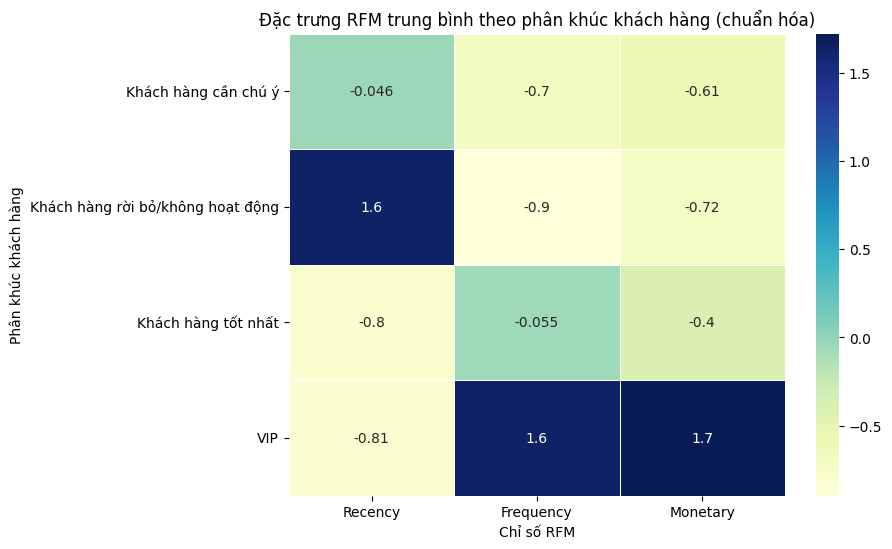

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- 1. Tính profile trung bình RFM theo cụm ---
cluster_profile = final_customer_segmentation.groupby('Cluster_Name')[['Recency','Frequency','Monetary']].mean()

# --- 2. Chuẩn hóa dữ liệu để so sánh ---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_profile_norm = pd.DataFrame(
    scaler.fit_transform(cluster_profile),
    index=cluster_profile.index,
    columns=cluster_profile.columns
)


print("Profile trung bình RFM theo cụm:")
display(cluster_profile)

print("\nProfile (chuẩn hóa 0-1) để so sánh trực quan:")
display(cluster_profile_norm)

# --- 3. Heatmap trực quan ---
plt.figure(figsize=(8,6))
sns.heatmap(cluster_profile_norm, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Đặc trưng RFM trung bình theo phân khúc khách hàng (chuẩn hóa)")
plt.ylabel("Phân khúc khách hàng")
plt.xlabel("Chỉ số RFM")
plt.show()


# Phân tích giỏ hàng – Luật kết hợp (Apriori / FP-Growth)

## Tiền xử lý dữ liệu cho luật kết hợp

Chuẩn bị dữ liệu giao dịch bằng cách tạo ra định dạng phù hợp cho thuật toán FP-Growth, trong đó mỗi hàng đại diện cho một hóa đơn và các cột là các sản phẩm (được mã hóa nhị phân).


In [ ]:
# Create a new DataFrame with 'InvoiceNo', 'StockCode', and 'Description'
basket_data = df[['InvoiceNo', 'StockCode', 'Description']].copy()

# Convert StockCode and Description to string type to avoid TypeError during concatenation
basket_data['StockCode'] = basket_data['StockCode'].astype(str)
basket_data['Description'] = basket_data['Description'].astype(str)


# Create a combined identifier for each item
basket_data['Item'] = basket_data['StockCode'] + ' - ' + basket_data['Description']

# Remove duplicate items within each invoice
basket_data = basket_data[['InvoiceNo', 'Item']].drop_duplicates()

# Convert data to one-hot encoded format using pivot_table
basket_pivot = basket_data.pivot_table(index='InvoiceNo', columns='Item', aggfunc='size', fill_value=0)

# Apply binary encoding: 1 if the item is present (count > 0), 0 otherwise
basket_encoded = basket_pivot.applymap(lambda x: 1 if x > 0 else 0)

# Display the first 5 rows of the preprocessed DataFrame
display(basket_encoded.head())

Item,10002 - inflatable political globe,10080 - groovy cactus inflatable,10120 - doggy rubber,10123C - hearts wrapping tape,10124A - spots on red bookcover tape,10124G - army camo bookcover tape,10125 - mini funky design tapes,10133 - colouring pencils brown tube,10135 - colouring pencils brown tube,11001 - asstd design racing car pen,...,M - manual,PADS - pads to match all cushions,POST - postage,S - samples,gift_0001_10 - dotcomgiftshop gift voucher £10.00,gift_0001_20 - dotcomgiftshop gift voucher £20.00,gift_0001_30 - dotcomgiftshop gift voucher £30.00,gift_0001_40 - dotcomgiftshop gift voucher £40.00,gift_0001_50 - dotcomgiftshop gift voucher £50.00,m - manual
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Group by product (StockCode or Description) and count the number of unique invoices they appear in
# Using combined Item for consistency with association rules preprocessing
item_transaction_counts = basket_data.groupby('Item')['InvoiceNo'].nunique().reset_index()

# Rename the count column for clarity
item_transaction_counts.rename(columns={'InvoiceNo': 'Transaction_Count'}, inplace=True)

# Sort by transaction count in descending order to see the most frequent items
top_items_by_transactions = item_transaction_counts.sort_values(by='Transaction_Count', ascending=False)

print("Top 10 items by number of transactions:")
display(top_items_by_transactions.head(10))

Top 10 items by number of transactions:


,Item,Transaction_Count
3637,85123A - white hanging heart t-light holder,2189
3616,85099B - jumbo bag red retrospot,2089
1340,22423 - regency cakestand 3 tier,1988
2874,47566 - party bunting,1685
179,20725 - lunch bag red retrospot,1564
3413,84879 - assorted colour bird ornament,1455
1630,22720 - set of 3 cake tins pantry design,1385
448,21212 - pack of 72 retrospot cake cases,1320
182,20727 - lunch bag black skull.,1273
1373,22457 - natural slate heart chalkboard,1249


## Áp dụng thuật toán fp-growth

### Subtask:
Sử dụng thuật toán FP-Growth để tìm các tập mục phổ biến (frequent itemsets) dựa trên ngưỡng hỗ trợ (support) đã chọn.


Top 10 Frequent Itemsets:


,support,itemsets
0,0.109675,85123A - white hanging heart t-light holder
93,0.104665,85099B - jumbo bag red retrospot
300,0.099604,22423 - regency cakestand 3 tier
590,0.084423,47566 - party bunting
42,0.078361,20725 - lunch bag red retrospot
7,0.072899,84879 - assorted colour bird ornament
621,0.069392,22720 - set of 3 cake tins pantry design
43,0.066136,21212 - pack of 72 retrospot cake cases
175,0.063781,20727 - lunch bag black skull.
80,0.062578,22457 - natural slate heart chalkboard



Shape of frequent itemsets DataFrame: (1875, 2)


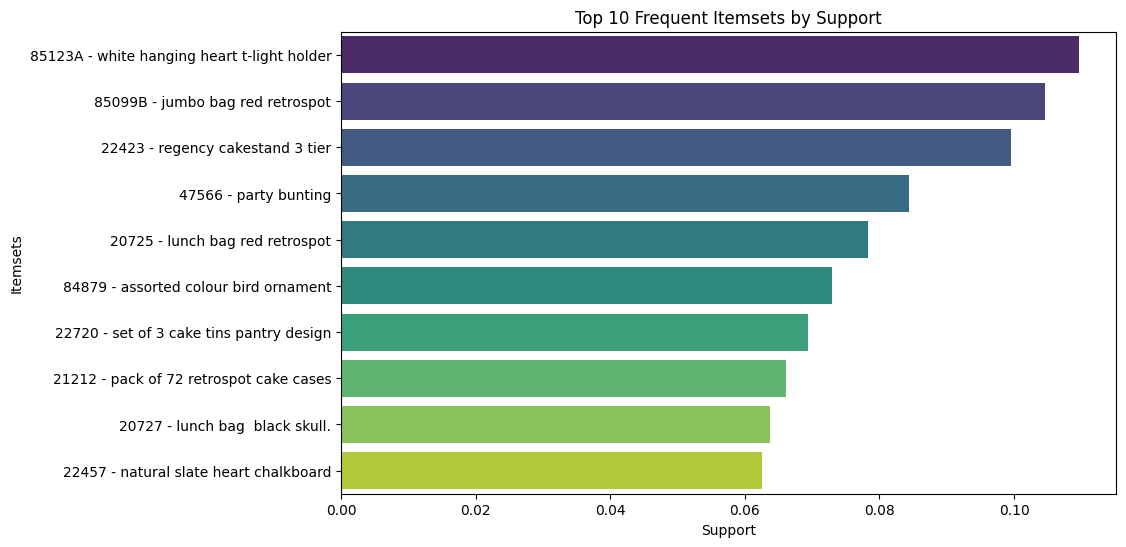

In [ ]:
frequent_itemsets = fpgrowth(basket_encoded, min_support=0.01, use_colnames=True)

# Sort frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False).copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert frozensets to strings and remove parentheses for better display
frequent_itemsets_sorted['itemsets'] = frequent_itemsets_sorted['itemsets'].apply(
    lambda x: ', '.join(list(x))
)


print("Top 10 Frequent Itemsets:")
display(frequent_itemsets_sorted.head(10))

# Display the shape of the frequent itemsets DataFrame
print("\nShape of frequent itemsets DataFrame:", frequent_itemsets.shape)


# Optional: Visualize the top 10 frequent itemsets
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets_sorted.head(10), palette='viridis')
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

## Tạo luật kết hợp

Từ các tập mục phổ biến, tạo ra các luật kết hợp dựa trên ngưỡng tin cậy (confidence) đã chọn.


In [ ]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules from the frequent itemsets
# Use original_frequent_itemsets which was saved with the correct format
# Set the metric to 'lift' and the minimum threshold to 1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort the rules by lift in descending order to see potentially interesting relationships
rules_by_lift = rules.sort_values(by='lift', ascending=False)

# Display the first 10 rows of the rules DataFrame with specified columns
print("Association Rules (sorted by Lift):")
display(rules_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))

# Display the shape of the rules DataFrame
print("\nShape of rules DataFrame:", rules.shape)

Association Rules (sorted by Lift):


,antecedents,consequents,support,confidence,lift
1513,(22916 - herb marker thyme),"(22917 - herb marker rosemary, 22918 - herb ma...",0.010171,0.856540,79.514807
1512,"(22917 - herb marker rosemary, 22918 - herb ma...",(22916 - herb marker thyme),0.010171,0.944186,79.514807
1514,(22917 - herb marker rosemary),"(22916 - herb marker thyme, 22918 - herb marke...",0.010171,0.845833,79.258157
1511,"(22916 - herb marker thyme, 22918 - herb marke...",(22917 - herb marker rosemary),0.010171,0.953052,79.258157
1520,(22917 - herb marker rosemary),"(22920 - herb marker basil, 22916 - herb marke...",0.010021,0.833333,79.202381
1517,"(22920 - herb marker basil, 22916 - herb marke...",(22917 - herb marker rosemary),0.010021,0.952381,79.202381
1516,"(22920 - herb marker basil, 22917 - herb marke...",(22916 - herb marker thyme),0.010021,0.934579,78.705785
1521,(22916 - herb marker thyme),"(22920 - herb marker basil, 22917 - herb marke...",0.010021,0.843882,78.705785
1502,(22916 - herb marker thyme),(22917 - herb marker rosemary),0.011073,0.932489,77.548154
1503,(22917 - herb marker rosemary),(22916 - herb marker thyme),0.011073,0.920833,77.548154



Shape of rules DataFrame: (3296, 14)


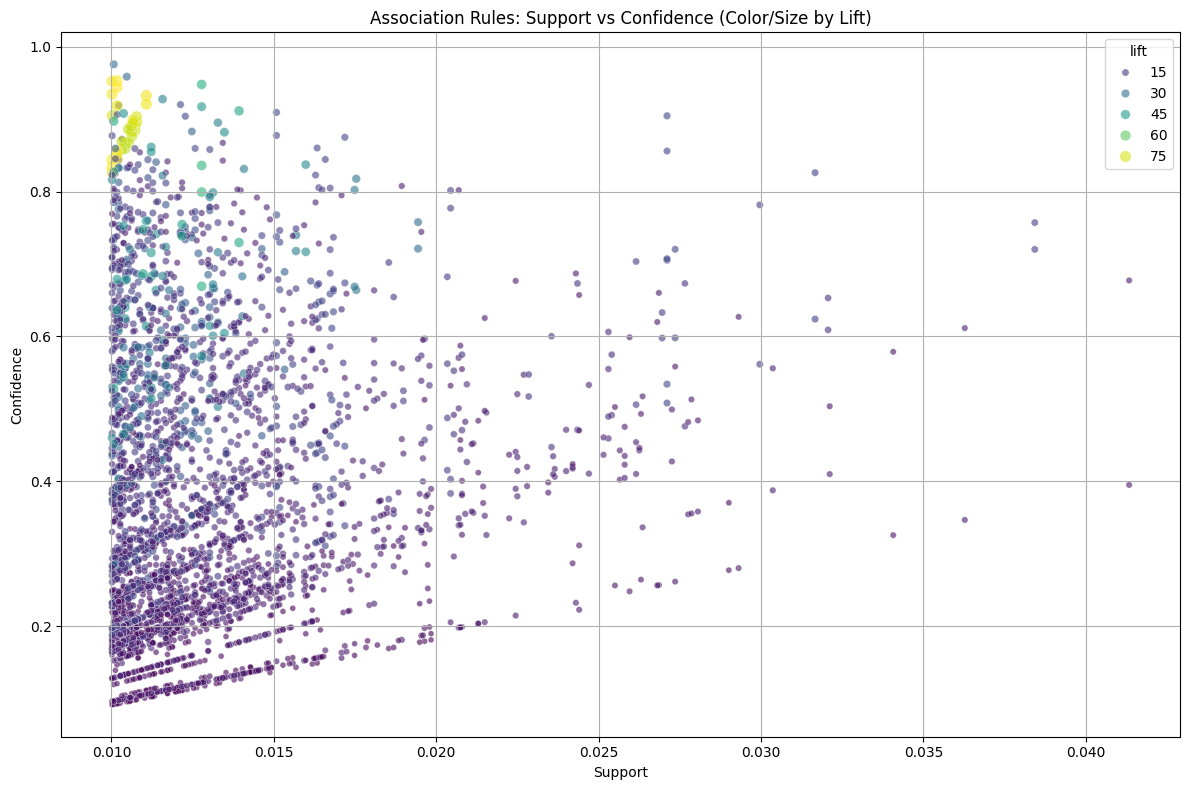

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter rules for visualization (e.g., lift > 1) - adjust threshold as needed
rules_filtered_lift = rules[rules['lift'] > 1].copy() # Use a copy to avoid SettingWithCopyWarning

# Create a scatter plot of support vs confidence, with color representing lift
plt.figure(figsize=(12, 8))
scatterplot = sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules_filtered_lift, alpha=0.6, palette='viridis')
plt.title('Association Rules: Support vs Confidence (Color/Size by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)

# Add a legend for the size (optional, can be tricky with continuous size)
# handles, labels = scatterplot.get_legend_handles_labels()
# plt.legend(handles=handles, labels=labels, title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

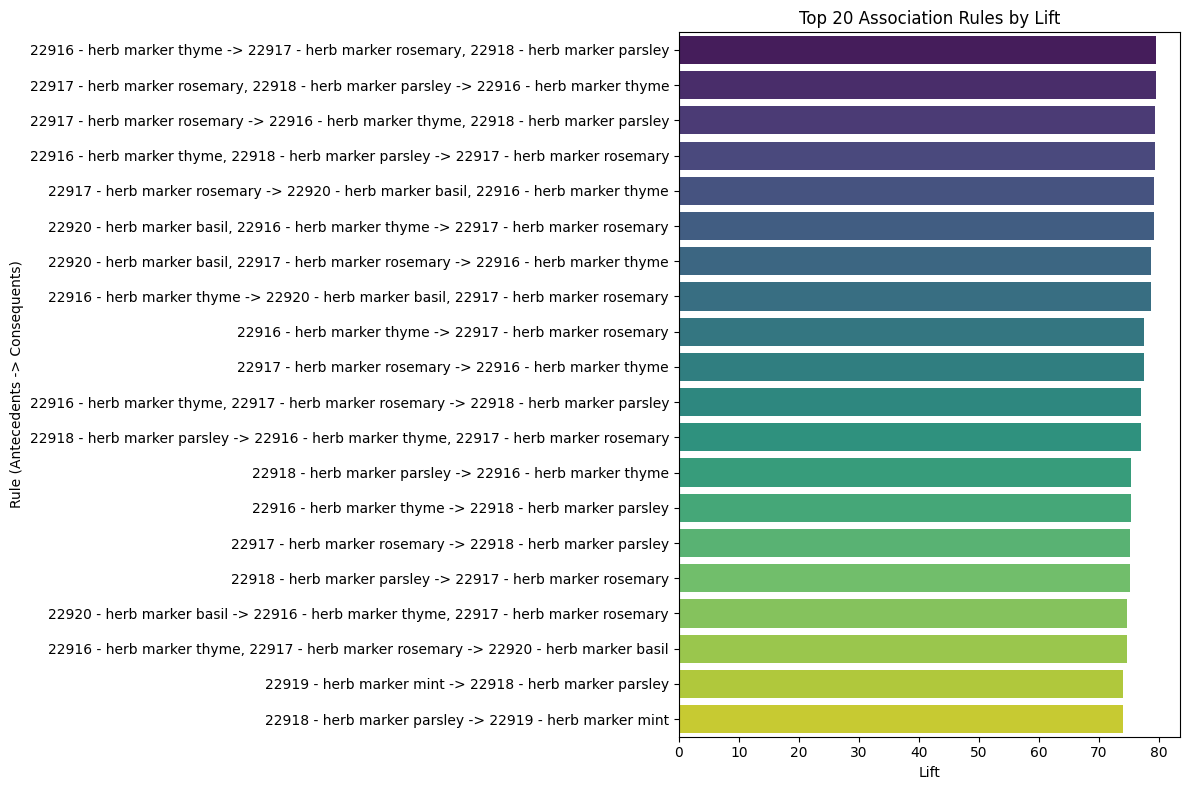

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort rules by lift and select the top N (e.g., top 20 rules with lift > 1)
top_rules_lift = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False).head(20).copy() # Use a copy to avoid SettingWithCopyWarning

# Create a string representation for each rule for plotting
top_rules_lift['Rule'] = top_rules_lift['antecedents'].apply(lambda x: ', '.join(list(x))) + ' -> ' + \
                         top_rules_lift['consequents'].apply(lambda x: ', '.join(list(x)))

# Create a bar plot of the top rules by lift
plt.figure(figsize=(12, 8))
sns.barplot(x='lift', y='Rule', data=top_rules_lift, palette='viridis')
plt.title('Top 20 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rule (Antecedents -> Consequents)')
plt.tight_layout()
plt.show()

## Lọc và diễn giải luật

thì sau khi có các sản phẩm có support cao thì chúng ta sẽ nâng cao bằng các chiến lượt kinh doanh sau:
- có thể đặt ở những kệ hàng dễ thấy, còn trên web thì để ở trang chủ.
- Có thể gợi ý Ví dụ, khi một người mua jumbo bag red retrospot, hãy gợi ý lunch bag red retrospot hoặc regency cakestand 3 tier vì chúng cũng là những sản phẩm bán chạy nhất.
- Tăng và đảm bảo hàng trong kho.

Còn đối với luật kết hơp thì:
- Tạo các gói combo như "Bộ Sưu Tập Thảo Mộc Nhà Bếp" bao gồm herb marker thyme, herb marker parsley, và herb marker rosemary. Bán gói này với giá ưu đãi hơn khi mua từng sản phẩm riêng lẻ.

-Khi khách hàng thêm một sản phẩm "herb marker" vào giỏ hàng, hệ thống phải tự động hiển thị gợi ý mạnh mẽ các sản phẩm liên quan. Sử dụng các luật đã tìm được, ví dụ: "Nếu bạn thích herb marker parsley, bạn chắc chắn sẽ thích herb marker thyme."

- Ví dụ: "Mua 3 sản phẩm herb marker, tặng 1 sản phẩm khác" hoặc "Giảm 20% khi mua trọn bộ". Mối liên kết mua sắm rất mạnh mẽ của các sản phẩm này sẽ đảm bảo tỷ lệ chuyển đổi cao.

# Ước tính giá trị vòng đời khách hàng (CLV)

In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.5 MB/s eta 0:00:00


In [ ]:
# CLEANED & COMPACT CLV PIPELINE (BG/NBD + Gamma-Gamma)
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# --- 0. Copy & filter customers (avoid modifying original df) ---
df_clean = df.copy()
df_clean = df_clean[df_clean['CustomerID'].notna()]
df_clean = df_clean[df_clean['CustomerID'] != 0]

# Ensure InvoiceDate datetime and create Amount if missing
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
if 'Amount' not in df_clean.columns:
    df_clean['Amount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# --- 1. Split historical / prediction by time (6 months cutoff) ---
latest_date = df_clean['InvoiceDate'].max()
cutoff_date = latest_date - timedelta(days=6*30)  # approx 6 months

df_historical = df_clean[df_clean['InvoiceDate'] <= cutoff_date].copy()
df_prediction = df_clean[df_clean['InvoiceDate'] > cutoff_date].copy()

print("Historical / Prediction shapes:", df_historical.shape, df_prediction.shape)
display(df_historical.head())
display(df_prediction.head())

Historical / Prediction shapes: (155862, 12) (242022, 12)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month,Amount
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,8,12,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,8,12,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,8,12,20.34


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month,Amount
223317,556480,21034,rex cash+carry jumbo shopper,1,2011-06-12 12:55:00,0.95,13617.0,United Kingdom,12,12,6,0.95
223318,556480,82482,wooden picture frame white finish,3,2011-06-12 12:55:00,2.55,13617.0,United Kingdom,12,12,6,7.65
223319,556480,22798,antique glass dressing table pot,4,2011-06-12 12:55:00,2.95,13617.0,United Kingdom,12,12,6,11.80
223320,556480,23321,small white heart of wicker,4,2011-06-12 12:55:00,1.69,13617.0,United Kingdom,12,12,6,6.76
223321,556480,85107,cut glass t-light holder octagon,1,2011-06-12 12:55:00,2.55,13617.0,United Kingdom,12,12,6,2.55


In [ ]:
historical_customers = df_historical['CustomerID'].nunique()
print("Số khách hàng trong historical:", historical_customers)

# Đếm số lượng khách hàng duy nhất trong tập prediction
prediction_customers = df_prediction['CustomerID'].nunique()
print("Số khách hàng trong prediction:", prediction_customers)

Số khách hàng trong historical: 2815
Số khách hàng trong prediction: 3478


Tạo RFM mới cho CLV

In [ ]:

# --- 2. Build RFM (lifetimes format) on historical data ---
rfm_historical = summary_data_from_transaction_data(
    df_historical,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Amount',
    observation_period_end=cutoff_date
)
# summary_data_from_transaction_data yields columns: frequency, recency, T, monetary_value

print("\nRFM (sample):")
display(rfm_historical.head())


RFM (sample):


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,145.0,0.000000
12347.0,3.0,184.0,187.0,498.053333
12348.0,2.0,110.0,178.0,297.220000
12350.0,0.0,0.0,130.0,0.000000
12352.0,3.0,34.0,116.0,421.770000


In [ ]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Fit BG/NBD
# Increased penalizer_coef to help with convergence
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_historical['frequency'], rfm_historical['recency'], rfm_historical['T'])

# Fit Gamma-Gamma (chỉ frequency > 0)
# Keep penalizer_coef for Gamma-Gamma as it might help with stability
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
    rfm_historical[rfm_historical['frequency'] > 0]['frequency'],
    rfm_historical[rfm_historical['frequency'] > 0]['monetary_value']
)

print("Models fitted successfully.")

Models fitted successfully.


Dự đoán CLV cho từng khách hàng trong 6 tháng tới

In [ ]:
# Dự đoán số lần mua lại trong 6 tháng (≈180 ngày)
rfm_historical['pred_purchases_6m'] = bgf.predict(
    180,
    rfm_historical['frequency'],
    rfm_historical['recency'],
    rfm_historical['T']
)

# Dự đoán giá trị trung bình mỗi đơn hàng
rfm_historical['pred_avg_order_value'] = ggf.conditional_expected_average_profit(
    rfm_historical['frequency'],
    rfm_historical['monetary_value']
)

# Dự đoán CLV = số lần mua × giá trị trung bình
rfm_historical['predicted_clv_6m'] = (
    rfm_historical['pred_purchases_6m'] *
    rfm_historical['pred_avg_order_value']
)


In [ ]:
# Tổng chi tiêu thật của khách trong 6 tháng prediction
actual_clv = (
    df_prediction.groupby('CustomerID')['Amount']
    .sum()
    .reset_index()
    .rename(columns={'Amount': 'actual_clv_6m'})
)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Merge dự đoán và thực tế
clv_compare = rfm_historical.reset_index()[['CustomerID','predicted_clv_6m']].merge(
    actual_clv, on='CustomerID', how='left'
).fillna(0)

# Tính RMSE, R²
# Remove squared=False as it's not supported in this scikit-learn version
rmse = np.sqrt(mean_squared_error(clv_compare['actual_clv_6m'], clv_compare['predicted_clv_6m']))
r2 = r2_score(clv_compare['actual_clv_6m'], clv_compare['predicted_clv_6m'])

print(f"Đánh giá mô hình CLV → RMSE: {rmse:.2f}, R²: {r2:.2f}")
display(clv_compare.head())

Đánh giá mô hình CLV → RMSE: 5134.32, R²: 0.50


,CustomerID,predicted_clv_6m,actual_clv_6m
0,12346.0,-487.813753,0.00
1,12347.0,1389.408148,2104.05
2,12348.0,625.173524,310.00
3,12350.0,-530.427059,0.00
4,12352.0,1708.672098,944.23


In [ ]:
# --- Phân nhóm CLV ---
clv_compare['clv_segment'] = pd.qcut(
    clv_compare['predicted_clv_6m'],
    q=3,
    labels=['Thấp', 'Trung bình', 'Cao']
)

# Xuất bảng kết quả
clv_table = clv_compare[['CustomerID','predicted_clv_6m','clv_segment']]
print("\nBảng phân nhóm CLV:")
display(clv_table.head(10))



Bảng phân nhóm CLV:


,CustomerID,predicted_clv_6m,clv_segment
0,12346.0,-487.813753,Thấp
1,12347.0,1389.408148,Cao
2,12348.0,625.173524,Cao
3,12350.0,-530.427059,Thấp
4,12352.0,1708.672098,Cao
5,12353.0,0.000000,Trung bình
6,12354.0,-971.922397,Thấp
7,12355.0,0.000000,Trung bình
8,12356.0,723.149418,Cao
9,12359.0,3481.061706,Cao


In [ ]:
import plotly.express as px
import pandas as pd

# Assuming clv_compare DataFrame with 'actual_clv_6m', 'predicted_clv_6m', and 'clv_segment' exists

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    clv_compare,
    x='actual_clv_6m',
    y='predicted_clv_6m',
    z='predicted_clv_6m', # You can use another dimension if available, or repeat predicted for a "flat" 3D look
    color='clv_segment',
    title='Predicted vs Actual CLV (6 months) by CLV Segment (3D)',
    labels={'actual_clv_6m': 'Actual CLV', 'predicted_clv_6m': 'Predicted CLV'},
    hover_data=['CustomerID'] # Add CustomerID to hover information
)

# Update layout for better viewing angles if needed
fig.update_layout(scene = dict(
                    xaxis_title='Actual CLV',
                    yaxis_title='Predicted CLV',
                    zaxis_title='Predicted CLV'), # Adjust z-axis title if using a different variable
                  margin=dict(l=0, r=0, b=0, t=40))


fig.show()

In [ ]:
# --- 0. Data Preparation như cũ ---
df_ml = df[df['CustomerID'] != 0].copy()
df_ml['InvoiceDate'] = pd.to_datetime(df_ml['InvoiceDate'])
if 'Amount' not in df_ml.columns:
    df_ml['Amount'] = df_ml['Quantity'] * df_ml['UnitPrice']

# Thay vì 6 tháng, ta chọn cutoff cố định, ví dụ train tới 2011-06-30
cutoff_date = pd.Timestamp('2011-06-30')

df_train = df_ml[df_ml['InvoiceDate'] <= cutoff_date].copy()
df_test  = df_ml[df_ml['InvoiceDate'] >  cutoff_date].copy()

# Thực tế CLV của giai đoạn test: 6 tháng sau cutoff
actual_clv_test = (
    df_test.groupby('CustomerID')['Amount']
    .sum()
    .reset_index()
    .rename(columns={'Amount': 'actual_clv_6m'})
)


# Hệ thống gợi ý (item-item hoặc user-item)

Gộp dữ liệu: mỗi dòng là một sản phẩm được mua bởi khách hàng.

Tạo matrix khách hàng–sản phẩm: hàng = CustomerID, cột = StockCode, giá trị = số lần mua hoặc 1/0 (nếu chỉ quan tâm đã mua hay chưa).

In [ ]:
# Create a DataFrame with CustomerID, StockCode, and Quantity
# We will use the original DataFrame 'df' which has already been cleaned
df_recommender = df[['CustomerID', 'StockCode', 'Quantity']].copy()

# Ensure CustomerID is not 0 as we are creating a customer-product matrix
df_recommender = df_recommender[df_recommender['CustomerID'] != 0]

# Số lượng khách hàng duy nhất
num_customers = df_recommender['CustomerID'].nunique()
print("Số lượng khách hàng duy nhất:", num_customers)

Số lượng khách hàng duy nhất: 4338


In [ ]:


# Create a customer-product matrix with the number of purchases
customer_product_matrix_count = df_recommender.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum', # Sum quantity for each customer-product pair
    fill_value=0
) # Added the missing closing parenthesis here

# Create a customer-product matrix with a binary indicator (1 if purchased, 0 otherwise)
customer_product_matrix_binary = customer_product_matrix_count.applymap(lambda x: 1 if x > 0 else 0)


print("Customer-Product Matrix (Purchase Count):")
display(customer_product_matrix_count.head())
print("\nShape of Purchase Count Matrix:", customer_product_matrix_count.shape)


print("\nCustomer-Product Matrix (Binary - Purchased or Not):")
display(customer_product_matrix_binary.head())
print("\nShape of Binary Purchase Matrix:", customer_product_matrix_binary.shape)

Customer-Product Matrix (Purchase Count):


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1



Shape of Purchase Count Matrix: (4338, 3665)

Customer-Product Matrix (Binary - Purchased or Not):


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1



Shape of Binary Purchase Matrix: (4338, 3665)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Calculate item similarity using cosine similarity on the transposed binary matrix
# Transpose the matrix to have items as rows and customers as columns
item_similarity_matrix = cosine_similarity(customer_product_matrix_binary.T)

# Convert the similarity matrix to a DataFrame for easier handling
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=customer_product_matrix_binary.columns, columns=customer_product_matrix_binary.columns)

print("Item Similarity Matrix (first 5x5):")
display(item_similarity_df.head())

Item Similarity Matrix (first 5x5):


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.000000,0.094868,0.090351,0.062932,0.098907,0.095346,0.047673,0.075593,0.090815,...,0.0,0.0,0.0,0.0,0.0,0.029361,0.0,0.067591,0.0,0.078217
10080,0.000000,1.000000,0.000000,0.032774,0.045655,0.047836,0.000000,0.000000,0.082261,0.049413,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016345,0.0,0.000000
10120,0.094868,0.000000,1.000000,0.057143,0.059702,0.041703,0.060302,0.060302,0.095618,0.028718,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071247,0.0,0.010993
10125,0.090351,0.032774,0.057143,1.000000,0.042644,0.044682,0.043073,0.000000,0.051224,0.030770,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071247,0.0,0.070669
10133,0.062932,0.045655,0.059702,0.042644,1.000000,0.280097,0.045002,0.060003,0.071358,0.057152,...,0.0,0.0,0.0,0.0,0.0,0.036955,0.0,0.070893,0.0,0.021877


In [ ]:
# Tạo bảng ánh xạ StockCode -> Description
stockcode_to_desc = df.drop_duplicates('StockCode').set_index('StockCode')['Description']

def recommend_items_for_user(customer_id, customer_product_matrix_binary, item_similarity_df, k=10):
    """
    Generates item recommendations for a customer based on their purchase history and item similarity.

    Args:
        customer_id: The ID of the customer.
        customer_product_matrix_binary (pd.DataFrame): The customer-product binary matrix.
        item_similarity_df (pd.DataFrame): The item similarity matrix.
        k (int): The number of recommendations to generate.

    Returns:
        tuple: (recommendations_df, purchased_list)
    """
    if customer_id not in customer_product_matrix_binary.index:
        print(f"Customer ID '{customer_id}' not found in the customer-product matrix.")
        return None, None

    # Lấy vector lịch sử mua của khách
    user_vector = customer_product_matrix_binary.loc[customer_id]

    # Tính điểm gợi ý
    item_scores = item_similarity_df.dot(user_vector)

    # Lấy danh sách sản phẩm đã mua
    purchased_items = user_vector[user_vector > 0].index
    purchased_list = [(code, stockcode_to_desc.get(code, "Unknown")) for code in purchased_items]

    # Loại bỏ sản phẩm đã mua khỏi gợi ý
    item_scores = item_scores.drop(purchased_items)

    # Lấy top-k gợi ý
    recommendations = item_scores.sort_values(ascending=False).head(k)

    # Đưa về DataFrame kèm Description
    recommendations_df = recommendations.to_frame(name="Score").reset_index()
    recommendations_df["Description"] = recommendations_df["StockCode"].map(stockcode_to_desc)

    return recommendations_df, purchased_list


# Example usage
example_customer_id = customer_product_matrix_binary.index[4]
print(f"Recommendations for Customer ID '{example_customer_id}':")
recommendations, purchased_list = recommend_items_for_user(example_customer_id, customer_product_matrix_binary, item_similarity_df)

print("\n📌 Danh sách sản phẩm đã mua:")
for code, desc in purchased_list:
    print(f"- {code}: {desc}")

print("\n📌 Gợi ý sản phẩm:")
display(recommendations)


Recommendations for Customer ID '12350.0':

📌 Danh sách sản phẩm đã mua:
- 20615: blue polkadot passport cover
- 20652: blue polkadot luggage tag
- 21171: bathroom metal sign
- 21832: chocolate calculator
- 21864: union jack flag passport cover
- 21866: union jack flag luggage tag
- 21908: chocolate this way metal sign
- 21915: red  harmonica in box
- 22348: tea bag plate red retrospot
- 22412: metal sign neighbourhood witch
- 22551: plasters in tin spaceboy
- 22557: plasters in tin vintage paisley
- 22620: 4 traditional spinning tops
- 79066K: retro mod tray
- 79191C: retro plastic elephant tray
- 84086C: pink/purple retro radio
- POST: postage

📌 Gợi ý sản phẩm:


,StockCode,Score,Description
0,22554,3.077102,plasters in tin woodland animals
1,22556,2.821355,plasters in tin circus parade
2,22555,2.779795,plasters in tin strongman
3,22553,2.632807,plasters in tin skulls
4,21914,2.541887,blue harmonica in box
5,20725,2.524668,lunch bag red retrospot
6,21165,2.498307,beware of the cat metal sign
7,22382,2.460049,lunch bag spaceboy design
8,21172,2.458502,party metal sign
9,21212,2.416571,pack of 72 retrospot cake cases


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# ======================================
# 1. Chuẩn bị dữ liệu
# ======================================
df_model = df[['CustomerID', 'StockCode', 'InvoiceDate', 'Quantity']].copy()

# Gom số lượng mua cho mỗi khách-sản phẩm
customer_product = df_model.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()

# Chia train/test (holdout)
train, test = train_test_split(customer_product, test_size=0.2, random_state=42)

# Tạo ma trận user-item (binary để đánh giá dễ hơn)
train_matrix = train.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
test_matrix = test.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)

# Tạo bảng ánh xạ StockCode -> Description (reuse from previous cell)
stockcode_to_desc = df.drop_duplicates('StockCode').set_index('StockCode')['Description']


# ======================================
# 2. Các hàm đánh giá
# ======================================
def precision_recall_at_k(recommendations, test_matrix, k=10):
    precisions, recalls = [], []
    for user in recommendations:
        if user not in test_matrix.index:
            continue
        true_items = set(test_matrix.loc[user][test_matrix.loc[user] > 0].index)
        if not true_items:
            continue
        rec_items = set([item for item, _ in recommendations[user][:k]])
        n_hit = len(true_items & rec_items)
        precisions.append(n_hit / k)
        recalls.append(n_hit / len(true_items))
    return np.mean(precisions), np.mean(recalls)

# ======================================
# 3. Baseline – gợi ý theo sản phẩm phổ biến
# ======================================
popular_items = train.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)

baseline_recommendations = defaultdict(list)
for user in train_matrix.index:
    baseline_recommendations[user] = [(item, 1.0) for item in popular_items.index]

p_baseline, r_baseline = precision_recall_at_k(baseline_recommendations, test_matrix, k=10)

# ======================================
# 4. Item-based CF – cosine similarity gợi ý theo hành vi của khách hàng
# ======================================
item_sim = cosine_similarity(train_matrix.T)
item_sim_df = pd.DataFrame(item_sim, index=train_matrix.columns, columns=train_matrix.columns)

cf_recommendations = defaultdict(list)
for user in train_matrix.index:
    user_vector = train_matrix.loc[user]
    purchased = user_vector[user_vector > 0].index
    if len(purchased) == 0:
        continue
    scores = item_sim_df[purchased].sum(axis=1)
    scores = scores.drop(purchased, errors='ignore')
    top_items = scores.sort_values(ascending=False).head(10)
    cf_recommendations[user] = list(top_items.items())

p_cf, r_cf = precision_recall_at_k(cf_recommendations, test_matrix, k=10)

# ======================================
# 5. Kết quả đánh giá
# ======================================
print("📊 Precision@10 / Recall@10")
print(f"Baseline: {p_baseline:.3f} / {r_baseline:.3f}")
print(f"CF      : {p_cf:.3f} / {r_cf:.3f}")

# ======================================
# 6. Top-10 sản phẩm gợi ý nhiều nhất (with Description)
# ======================================
def get_top10_all_users_with_desc(recommendations, stockcode_to_desc):
    all_items = []
    for recs in recommendations.values():
        all_items.extend([i for i, _ in recs])
    top_10_stockcodes = pd.Series(all_items).value_counts().head(10)
    top_10_with_desc = pd.DataFrame({
        'StockCode': top_10_stockcodes.index,
        'Count': top_10_stockcodes.values
    })
    top_10_with_desc['Description'] = top_10_with_desc['StockCode'].map(stockcode_to_desc)
    return top_10_with_desc[['StockCode', 'Description', 'Count']]


print("\n🔥 Top-10 sản phẩm (Baseline):")
display(get_top10_all_users_with_desc(baseline_recommendations, stockcode_to_desc))

print("\n🔥 Top-10 sản phẩm (CF):")
display(get_top10_all_users_with_desc(cf_recommendations, stockcode_to_desc))

📊 Precision@10 / Recall@10
Baseline: 0.021 / 0.021
CF      : 0.018 / 0.025

🔥 Top-10 sản phẩm (Baseline):


,StockCode,Description,Count
0,23843,"paper craft , little birdie",4311
1,23166,medium ceramic top storage jar,4311
2,22197,small popcorn holder,4311
3,84077,world war 2 gliders asstd designs,4311
4,85099B,jumbo bag red retrospot,4311
5,21212,pack of 72 retrospot cake cases,4311
6,84879,assorted colour bird ornament,4311
7,85123A,white hanging heart t-light holder,4311
8,22616,pack of 12 london tissues,4311
9,22492,mini paint set vintage,4311



🔥 Top-10 sản phẩm (CF):


,StockCode,Description,Count
0,22653,button box,2324
1,22327,round snack boxes set of 4 skulls,1916
2,20719,woodland charlotte bag,1868
3,22819,"birthday card, retro spot",1824
4,20723,strawberry charlotte bag,1739
5,20717,strawberry shopper bag,1666
6,22378,wall tidy retrospot,1520
7,22814,card party games,1423
8,22355,charlotte bag suki design,1164
9,21935,suki shoulder bag,998


baseline là gợi ý dựa trên 10 sản phẩm được mua nhiều nhất
còn CF thì sẽ phân tích hành vi tường tự và gợi món hàng mà họ chưa mua

Evaluation Metrics:


,Baseline,Item-based CF
Metric,,
Precision@10,0.020575,0.017997
Recall@10,0.021202,0.025331


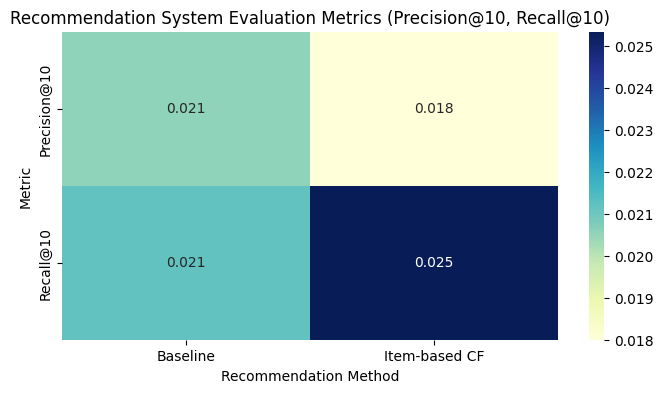

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming p_baseline, r_baseline, p_cf, r_cf are available from the previous evaluation cell

# Create a DataFrame for the heatmap
evaluation_data = {
    'Metric': ['Precision@10', 'Recall@10'],
    'Baseline': [p_baseline, r_baseline],
    'Item-based CF': [p_cf, r_cf]
}
evaluation_df = pd.DataFrame(evaluation_data).set_index('Metric')

print("Evaluation Metrics:")
display(evaluation_df)

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(evaluation_df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Recommendation System Evaluation Metrics (Precision@10, Recall@10)')
plt.ylabel('Metric')
plt.xlabel('Recommendation Method')
plt.show()

 Nghĩa là trong 10 sản phẩm được gợi ý, tỷ lệ sản phẩm mà người dùng thực sự mua (relevant items) khá thấp (~2%), và baseline cao hơn CF một chút.

 Nghĩa là trong toàn bộ sản phẩm mà người dùng thực sự quan tâm, hệ thống gợi ý đã tìm ra được khoảng 2%, và CF bắt được nhiều hơn baseline

Thế nên xét theo tính gợi ý theo sản phẩm có liên quan thì dùng CF

In [ ]:
# Chọn một CustomerID để gợi ý
# Thay thế bằng CustomerID mà bạn muốn
customer_id_to_recommend = 12590.0  # Ví dụ

# Lấy gợi ý và danh sách sản phẩm đã mua
recommendations_df, purchased_list = recommend_items_for_user(
    customer_id_to_recommend,
    customer_product_matrix_binary,
    item_similarity_df
)

if recommendations_df is not None:
    print(f"\n📌 Danh sách sản phẩm đã mua của Khách hàng {customer_id_to_recommend}:")
    if purchased_list:
        for code, desc in purchased_list:
            print(f"- {code}: {desc}")
    else:
        print("Không có dữ liệu lịch sử mua hàng.")

    print(f"\n📌 Gợi ý sản phẩm cho Khách hàng {customer_id_to_recommend}:")
    if not recommendations_df.empty:
        display(recommendations_df)
    else:
        print("Không có gợi ý nào được tạo ra.")


📌 Danh sách sản phẩm đã mua của Khách hàng 12590.0:
- 15036: assorted colours silk fan
- 20679: edwardian parasol red
- 20685: doormat red retrospot
- 20719: woodland charlotte bag
- 20723: strawberry charlotte bag
- 20724: red retrospot charlotte bag
- 20725: lunch bag red retrospot
- 20726: lunch bag woodland
- 21035: set/2 red retrospot tea towels
- 21039: red retrospot shopping bag
- 21121: set/10 red polkadot party candles
- 21154: red retrospot oven glove
- 21155: red retrospot peg bag
- 21164: home sweet home metal sign
- 21165: beware of the cat metal sign
- 21523: doormat fancy font home sweet home
- 21559: strawberry lunch box with cutlery
- 21731: red toadstool led night light
- 21907: i'm on holiday metal sign
- 21936: red retrospot picnic bag
- 21937: strawberry   picnic bag
- 22179: set 10 lights night owl
- 22195: large heart measuring spoons
- 22243: 5 hook hanger red magic toadstool
- 22329: round container set of 5 retrospot
- 22352: lunch box with cutlery retrospot


,StockCode,Score,Description
0,22382,14.565212,lunch bag spaceboy design
1,23206,13.935100,lunch bag apple design
2,20727,13.693169,lunch bag black skull.
3,22383,13.586958,lunch bag suki design
4,20728,13.581183,lunch bag cars blue
5,22384,13.579926,lunch bag pink polkadot
6,85099B,13.433835,jumbo bag red retrospot
7,23207,13.332536,lunch bag alphabet design
8,21212,13.250190,pack of 72 retrospot cake cases
9,23208,12.726520,lunch bag vintage leaf design


# Dự báo chuỗi thời gian (doanh thu / nhu cầu theo loại)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Gộp theo ngày, chỉ những ngày có bán
daily_revenue = (
    df.resample('D', on='InvoiceDate')['Amount']
      .sum()
      .loc[lambda x: x > 0]      # lọc doanh thu > 0
)

print(daily_revenue.head())

# Gộp theo tháng, chỉ tháng có bán
monthly_revenue = (
    df.resample('M', on='InvoiceDate')['Amount']
      .sum()
      .loc[lambda x: x > 0]
)

print(monthly_revenue.head())


InvoiceDate
2010-12-01    58960.79
2010-12-02    47748.38
2010-12-03    46943.71
2010-12-05    31774.95
2010-12-06    54830.46
Name: Amount, dtype: float64
InvoiceDate
2010-12-31    823746.140
2011-01-31    691364.560
2011-02-28    523631.890
2011-03-31    717639.360
2011-04-30    537808.621
Freq: ME, Name: Amount, dtype: float64


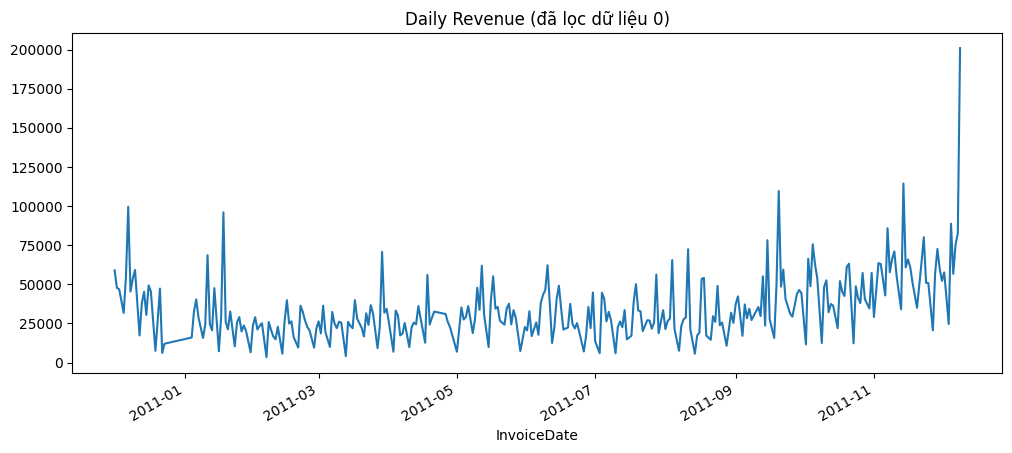

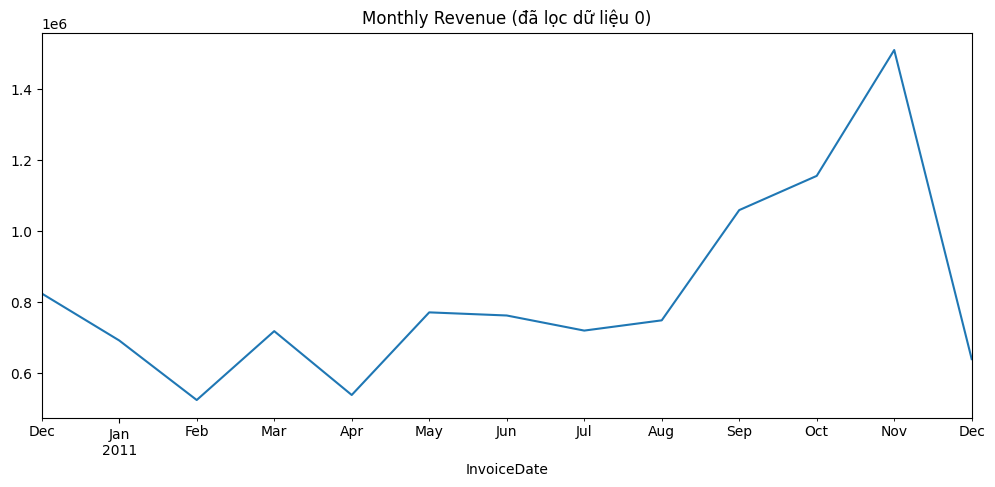

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣  Bỏ các dòng Quantity = 0 hoặc UnitPrice = 0
df_clean = df[(df['Quantity'] != 0) & (df['UnitPrice'] != 0)].copy()

# 2️⃣  Tạo cột Amount
df_clean['Amount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 3️⃣  Doanh thu theo ngày
daily_revenue = (
    df_clean.resample('D', on='InvoiceDate')['Amount']
             .sum()
             .loc[lambda x: x > 0]      # lọc doanh thu > 0
)

# 4️⃣  Doanh thu theo tháng
monthly_revenue = (
    df_clean.resample('M', on='InvoiceDate')['Amount']
             .sum()
             .loc[lambda x: x > 0]
)

# 5️⃣  Vẽ biểu đồ
plt.figure(figsize=(12,5))
daily_revenue.plot(title='Daily Revenue (đã lọc dữ liệu 0)')
plt.show()

plt.figure(figsize=(12,5))
monthly_revenue.plot(title='Monthly Revenue (đã lọc dữ liệu 0)')
plt.show()

Kiem tra tinh dung

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(daily_revenue)
print("ADF p-value:", adf_result[1])


ADF p-value: 0.9616817472846348


thì theo p-value  thì nó lơn hơn 0.05 nên cho rằng không có tính dừng nghĩa là dữ liệu thay đổi và biến động lên xuống

In [ ]:
train_size = int(len(daily_revenue) * 0.8)
train, test = daily_revenue[:train_size], daily_revenue[train_size:]


Dựa vào hai biểu đồ  đồ thị Tự tương quan (Autocorrelation - ACF) và Tự tương quan riêng phần (Partial Autocorrelation - PACF), được dùng để xác định các tham số cho mô hình dự đoán chuỗi thời gian như ARIMA.

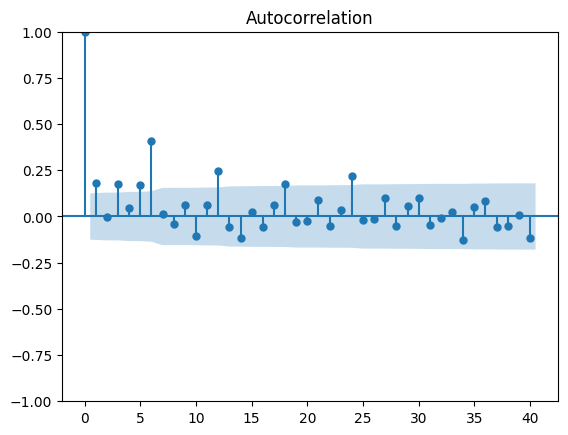

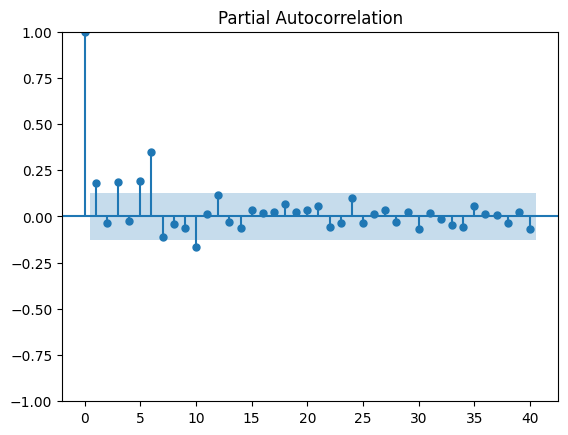

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train, lags=40)
plot_pacf(train, lags=40)
plt.show()


Dùng ARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Explicitly set the frequency of the daily_revenue Series
train = train.asfreq('D')

model = SARIMAX(
    train,
    order=(1,1,1),          # p,d,q
    seasonal_order=(1,1,1,7) # P,D,Q,s với s=7 cho tuần
)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

In [ ]:

# ----- Gộp Actual & Predict -----
result_df = pd.DataFrame({
    "Actual": test,
    "Predicted": forecast
})
print(result_df.head(15))
# Tính giá trị trung bình của tập dữ liệu kiểm tra (test)
test_trung_binh = test.mean()

print(f"Giá trị trung bình của tập dữ liệu test là: {test_trung_binh}")     # in 15 dòng đầu

              Actual     Predicted
2011-09-30  44357.06  35053.481283
2011-10-01       NaN  28808.332348
2011-10-02  11634.53  24213.632990
2011-10-03  66376.82  36170.910016
2011-10-04  48810.65  45343.452249
2011-10-05  75593.63  39928.685812
2011-10-06  62891.19  49243.785170
2011-10-07  53790.70  35216.603704
2011-10-08       NaN  28846.718219
2011-10-09  12524.40  24080.267333
2011-10-10  48239.18  37458.427692
2011-10-11  52572.94  46852.809327
2011-10-12  32159.28  40134.149382
2011-10-13  37446.18  50125.796150
2011-10-14  36347.64  35826.561024
Giá trị trung bình của tập dữ liệu test là: 54879.10442622952


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae  = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE : 22374.92
RMSE: 31039.33


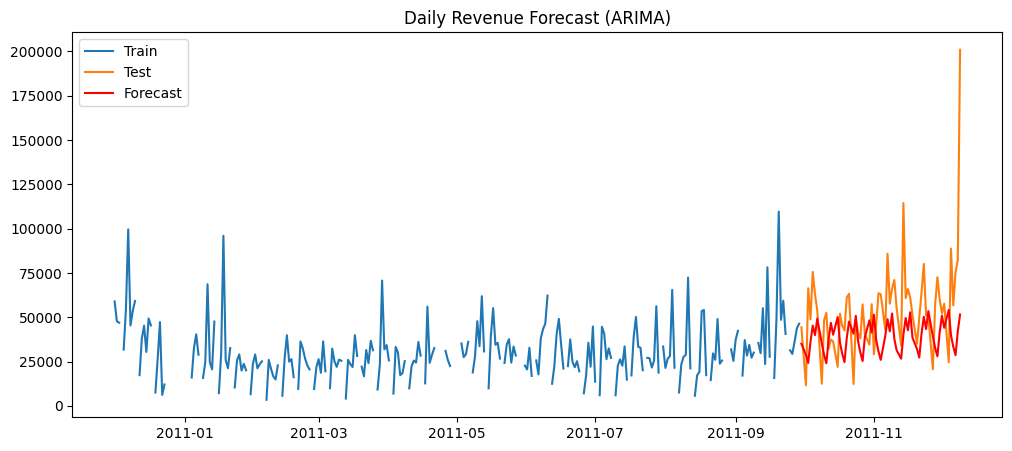

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("Daily Revenue Forecast (ARIMA)")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it ha

Rolling MAE : 11892.07936867042
Rolling RMSE: 15121.753538659792


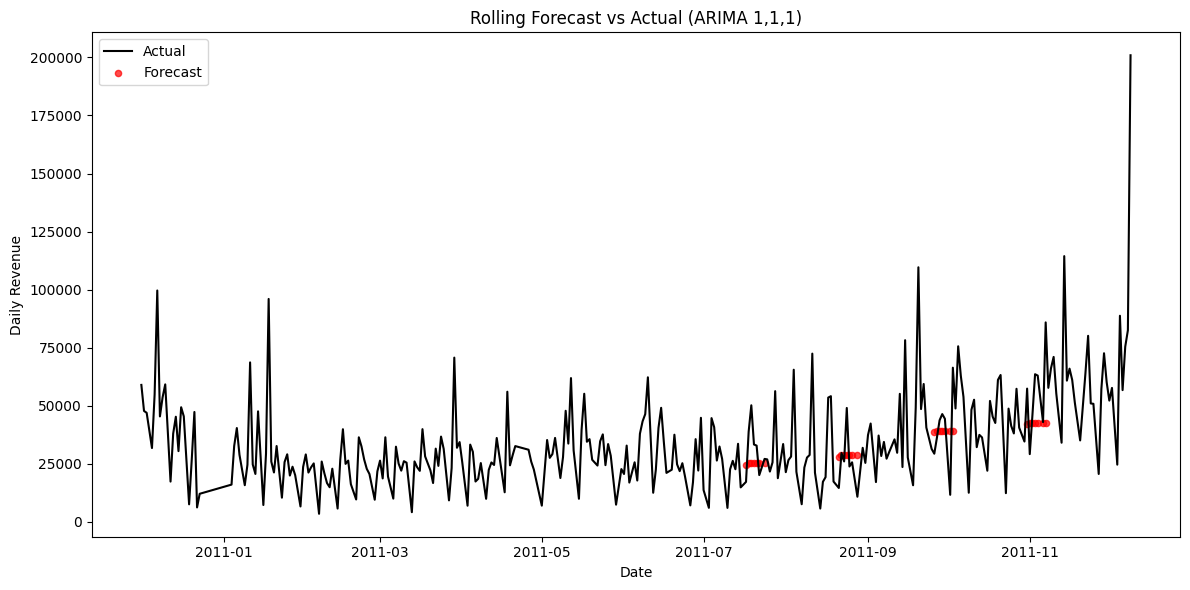

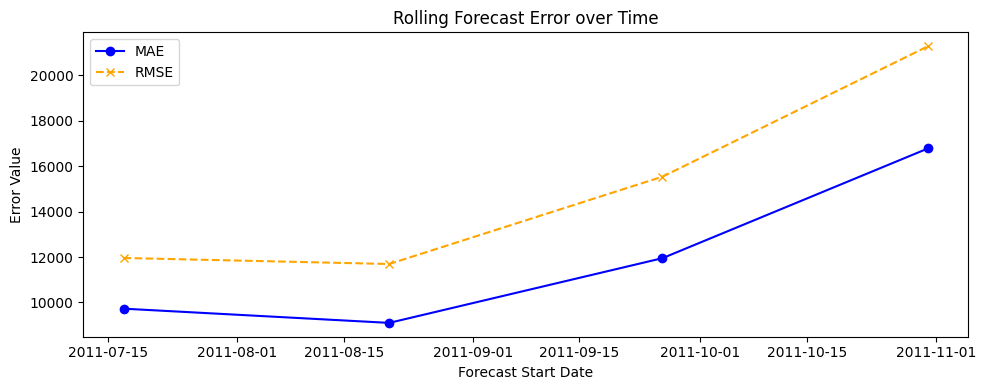

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

window = 180          # 6 tháng train
horizon = 7           # dự báo 7 ngày
mae_list, rmse_list, forecast_dates = [], [], []
all_forecasts = []    # để vẽ Actual vs Forecast

for start in range(0, len(daily_revenue)-window-horizon, 30):  # bước 30 ngày
    train_end = start + window
    test_end  = train_end + horizon

    train = daily_revenue.iloc[start:train_end]
    test  = daily_revenue.iloc[train_end:test_end]

    model = ARIMA(train, order=(1,1,1))
    fit   = model.fit()
    forecast = fit.forecast(steps=horizon)

    # Lưu giá trị để vẽ
    all_forecasts.append((test.index, forecast))
    forecast_dates.append(test.index[0])

    mae  = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae_list.append(mae)
    rmse_list.append(rmse)

print("Rolling MAE :", np.mean(mae_list))
print("Rolling RMSE:", np.mean(rmse_list))

# ==== 1️⃣ Biểu đồ Actual vs Forecast của từng cửa sổ ====
plt.figure(figsize=(12,6))
plt.plot(daily_revenue.index, daily_revenue, label="Actual", color="black", linewidth=1.5)
for dates, forecast in all_forecasts:
    plt.scatter(dates, forecast, color="red", s=20, alpha=0.7, label="Forecast" if dates is all_forecasts[0][0] else "")
plt.title("Rolling Forecast vs Actual (ARIMA 1,1,1)")
plt.xlabel("Date")
plt.ylabel("Daily Revenue")
plt.legend()
plt.tight_layout()
plt.show()

# ==== 2️⃣ Biểu đồ lỗi theo thời gian ====
plt.figure(figsize=(10,4))
plt.plot(forecast_dates, mae_list, marker='o', linestyle='-', label="MAE", color="blue")
plt.plot(forecast_dates, rmse_list, marker='x', linestyle='--', label="RMSE", color="orange")
plt.title("Rolling Forecast Error over Time")
plt.xlabel("Forecast Start Date")
plt.ylabel("Error Value")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for i, (dates, forecast) in enumerate(all_forecasts):
    print(f"\n--- Window {i+1} ---")
    print("Dự báo cho các ngày:", dates[0].date(), "->", dates[-1].date())
    actual_vals = daily_revenue.loc[dates]
    for d, a, f in zip(dates, actual_vals, forecast):
        print(f"{d.date()} | Actual: {a:,.0f} | Forecast: {f:,.0f}")



--- Window 1 ---
Dự báo cho các ngày: 2011-07-17 -> 2011-07-24
2011-07-17 | Actual: 17,195 | Forecast: 24,676
2011-07-18 | Actual: 38,832 | Forecast: 25,342
2011-07-19 | Actual: 50,183 | Forecast: 25,387
2011-07-20 | Actual: 33,308 | Forecast: 25,390
2011-07-21 | Actual: 32,819 | Forecast: 25,390
2011-07-22 | Actual: 20,125 | Forecast: 25,390
2011-07-24 | Actual: 27,099 | Forecast: 25,390

--- Window 2 ---
Dự báo cho các ngày: 2011-08-21 -> 2011-08-28
2011-08-21 | Actual: 14,577 | Forecast: 27,944
2011-08-22 | Actual: 29,651 | Forecast: 28,833
2011-08-23 | Actual: 25,994 | Forecast: 28,907
2011-08-24 | Actual: 49,035 | Forecast: 28,914
2011-08-25 | Actual: 23,827 | Forecast: 28,914
2011-08-26 | Actual: 25,626 | Forecast: 28,914
2011-08-28 | Actual: 10,805 | Forecast: 28,914

--- Window 3 ---
Dự báo cho các ngày: 2011-09-26 -> 2011-10-03
2011-09-26 | Actual: 29,335 | Forecast: 38,700
2011-09-27 | Actual: 36,323 | Forecast: 39,250
2011-09-28 | Actual: 43,749 | Forecast: 39,292
2011-09-2